In [1]:
import numpy as np
from scipy.linalg import lu_factor, lu_solve

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
sns.set(color_codes=True)

from tqdm import tqdm

In [2]:
from synthetic_datasets import *
from loss_models import *
from plot import *

# Why $|I_{pred}| > |I_{actual}|$ (self) when adding a single point

We expect the predicted influence to overestimate actual influence when adding points, because
1. Loss of point should decrease
2. Gradient of loss at point should decrease
3. Hessian of point should become more PSD, at least in the direction of that point ($+ xx^T$)

And we think this should depend on where the added point is, and how certain the model is about the point. So, let's fix a dataset $Z_\text{orig}$, and pick an arbitrary point $z_\text{new}$ $(y_\text{new} = +1)$, and plot
1. $\ell(z_\text{test}, \theta(s))$,
   $\ell(z_\text{test}, \theta(s + tw))$
2. $\lVert \nabla_\theta l(z_\text{test}, \theta(s)) \rVert$,
   $\lVert \nabla_\theta l(z_\text{test}, \theta(s + tw)) \rVert$
   (we already know these should be (anti-)parallel to x)
3. $H(s, \theta(s))$,
   $H(s, \theta(s + tw))$,
   $H(s + tw, \theta(s))$,
   $H(s + tw, \theta(s + tw))$,
   but it is unclear how to visualize this. Hence, we will try:
    * $\lambda_1(H), \lambda_2(H)$
    * $x_\text{new}^T H(s+tw,\theta(s+tw)) x_\text{new}$

against $t \in [0, 1]$, where
* $s = [1, \dots, 1, 1]$
* $w = [0, \dots, 0, 1]$
* $Z = [Z_\text{orig}, z_\text{new}]$

For self influence, the gradients are the same, so let
$$g_{s+tw} = \nabla_\theta \ell(z_{new}, \theta(s+tw))$$
$$H_{s+tw} = H(s+tw, \theta(s+tw))$$

And then the influence is going to be
$$\int_0^1 g_{s+tw}^T H^{-1}_{s+tw} g_{s+tw} - g_s H^{-1}_s g_s dt$$

For margin-based losses, gradients are always in the direction of the point, so
let $r_t$ be so $g_{s+tw} = r_t g_s$

For adding points, we expect $r_t \le 1$ and $H_{s+tw} \ge H_s$, so the actual - predicted integral
$g_{s+tw}^T H^{-1}_{s+tw} g_{s+tw} - g_s^T H^{-1}_s g_{s}
\le g_s^T (H^{-1}_{s+tw} - H^{-1}_s) g_s^T
\le 0$

In [7]:
def sample_integral(X_orig, y_orig, z_new, z_test=None, title="", lm=LogisticRegression(), t_samples=50,
                    row_types=["dataset", "self_infl_factors", "integrands"]):
    z_test_same = z_test is None
    z_test = z_test if z_test is not None else z_new
    
    N, D = X_orig.shape
    X = np.vstack([X_orig, z_new[0]])
    y = np.hstack([y_orig, z_new[1]])
    s, w = np.ones(N + 1), np.zeros(N + 1)
    w[-1] = 1
    
    # convention: capital T means plural
    T = np.linspace(0, 1, t_samples)
    theta_sTw = [lm.theta(X, y, s + t * w) for t in T]
    theta_s = lm.theta(X, y, s)
    
    d_theta = theta_s / np.linalg.norm(theta_s)
    
    # Losses
    l_sTw = np.array([lm.L(z_test[0], z_test[1], 1, theta_stw) for theta_stw in theta_sTw])
    l_s = lm.L(z_test[0], z_test[1], 1, theta_s)
    
    # Gradients, specialized for single point w.
    g_sTw = np.array([lm.g(z_new[0], z_new[1], 1, theta_stw) for theta_stw in theta_sTw])
    g_s = lm.g(z_new[0], z_new[1], 1, theta_s)
    
    # Gradients and norms, of test point
    gradl_sTw = np.array([lm.g(z_test[0], z_test[1], 1, theta_stw) for theta_stw in theta_sTw])
    gradl_s = lm.g(z_test[0], z_test[1], 1, theta_s)
    norm_gradl_sTw = np.linalg.norm(gradl_sTw, axis=1)
    norm_gradl_s = np.linalg.norm(gradl_s)
    r_T = np.dot(gradl_sTw, gradl_s) / (norm_gradl_s ** 2.0)
    
    # Sanity check: gradients in the same direction?
    crosses = np.array([np.cross(gradl_stw, gradl_s) for gradl_stw in gradl_sTw])
    assert(np.max(np.abs(crosses)) <= 1e-6)
    
    # Hessians
    H_sTw_s = np.array([lm.H(X, y, s + t * w, theta_s) for t in T])
    H_s_sTw = np.array([lm.H(X, y, s, theta_stw) for theta_stw in theta_sTw])
    H_sTw_sTw = np.array([lm.H(X, y, s + t * w, theta_stw) for (t, theta_stw) in zip(T, theta_sTw)])
    H_s_s = lm.H(X, y, s, theta_s)
    
    # Eigenvalues
    eig_sTw_s = np.array([np.linalg.eigvalsh(H_stw_s) for H_stw_s in H_sTw_s])
    eig_s_sTw = np.array([np.linalg.eigvalsh(H_s_stw) for H_s_stw in H_s_sTw])
    eig_sTw_sTw = np.array([np.linalg.eigvalsh(H_stw_stw) for H_stw_stw in H_sTw_sTw])
    eig_s_s = np.linalg.eigvalsh(H_s_s)
    
    # Hessian quadratic products
    xHx_sTw_sTw_new = z_new[0].T.dot(H_sTw_sTw).dot(z_new[0])
    xHx_sTw_sTw_test = z_test[0].T.dot(H_sTw_sTw).dot(z_test[0])
    
    # Test influence
    inv_prod = lambda a, H, b: a.dot(lu_solve(lu_factor(H), b))
    I_pred = -inv_prod(gradl_s, H_s_s, g_s)
    I_actl = lm.L(z_test[0], z_test[1], 1, theta_sTw[-1]) - lm.L(z_test[0], z_test[1], 1, theta_s)
    
    # Integrands
    gHg_sTw = np.array([inv_prod(gradl_stw, H_stw_stw, g_stw)
                        for (gradl_stw, H_stw_stw, g_stw) in zip(gradl_sTw, H_sTw_sTw, g_sTw)])
    gHg_s = inv_prod(gradl_s, H_s_s, g_s)
    
    fig, axs = plt.subplots(len(row_types), 2, figsize=(16, 16 / 2 * len(row_types)))
    
    for ax_row, row_type in zip(axs, row_types):
        if row_type == "dataset":
            # Plot dataset and points
            annotations = ([(z_new[0], z_new[1], '$z_{new}$')]
                           + ([] if z_test_same else [(z_test[0], z_test[1], '$z_{test}$')]))
            plot_dataset(ax_row[0], X_orig, y_orig, annotations)
            plot_decision_boundary(axs[0][0], d_theta)
            plot_hessian(ax_row[0], H_s_s)

            # Plot loss
            plot_dataset(ax_row[1], X_orig, y_orig, annotations,
                         title='Loss',
                         grid_function=lambda x: lm.L(x, 1, 1, theta_s))
    
        elif row_type == "loss":
            # Plot test loss
            plot_lines(ax_row[0], T,
                       [(l_s,  '$\\ell(z_{test}, \\theta(s))$'),
                        (l_sTw, '$\\ell(z_{test}, \\theta(s + tw))$')],
                       title='Loss of point should decrease')

            # Plot loss gradient norms
            plot_lines(ax_row[1], T,
                       [(norm_gradl_s,  '$\\Vert \\nabla_\\theta(z_{test}, \\theta(s)) \\Vert$'),
                        (norm_gradl_sTw, '$\\Vert \\nabla_\\theta(z_{test}, \\theta(s + tw)) \\Vert$')],
                       title='Gradient of point should decrease')
    
        elif row_type == "hess_eig":
            # Using eigenvalues
            plot_lines(ax_row[0], T,
                       [(eig_s_s[0], '$\\lambda_1(H(s, \\theta(s)))$'),
                        (eig_sTw_s[:, 0], '$\\lambda_1(H(s + tw, \\theta(s)))$'),
                        (eig_s_sTw[:, 0], '$\\lambda_1(H(s, \\theta(s + tw)))$'),
                        (eig_sTw_sTw[:, 0], '$\\lambda_1(H(s + tw, \\theta(s + tw)))$'),
                       ],
                       title='Smaller eigenvalue should ???')
            plot_lines(ax_row[1], T,
                       [(eig_s_s[1], '$\\lambda_2(H(s, \\theta(s)))$'),
                        (eig_sTw_s[:, 1], '$\\lambda_2(H(s + tw, \\theta(s)))$'),
                        (eig_s_sTw[:, 1], '$\\lambda_2(H(s, \\theta(s + tw)))$'),
                        (eig_sTw_sTw[:, 1], '$\\lambda_2(H(s + tw, \\theta(s + tw)))$'),
                       ],
                       title='Larger eigenvalue should increase')

        elif row_type == "hess_prod":
            # Using quadratic products in direction of z_new
            plot_lines(ax_row[0], T,
                       [(xHx_sTw_sTw_new, '$x_{new}^T H(s+tw, \\theta(s+tw)) x_{new}$')],
                       title='PSD-ness of H in the direction of $x_{new}$ should increase')
            
            # Using quadratic products in direction of z_test
            plot_lines(ax_row[1], T,
                       [(xHx_sTw_sTw_test, '$x_{test}^T H(s+tw, \\theta(s+tw)) x_{test}$')],
                       title='PSD-ness of H in the direction of $x_{test}$ should ???')
        
        elif row_type == "integrands":
            # Plot the things we integrate
            plot_lines(ax_row[0], T,
                       [(gHg_sTw, '$g_{s+tw}^T H^{-1}_{s+tw} g_{s+tw}$'),
                        (gHg_s, '$g_s^T H^{-1}_s g_s$')],
                       title='For overestimating, the curve should be under the line')            
        
            plot_lines(ax_row[1], T,
                       [(I_pred, '$-\\nabla_\\theta \ell(z_{test}, \\theta(s)) H^{-1}(s, \\theta(s)) g(w, \\theta(s))$'),
                        (I_actl, '$\ell(z_{test}, \\theta(s+w)) - \ell(z_{test}, \\theta(s))$')],
                       title='Actual and predicted influence')
        
        elif row_type == "self_infl_factors":
            # Plot the ratio
            plot_lines(ax_row[0], T,
                       [(r_T, '$r_t$')],
                       title='The gradient scaling factor should decrease <= 1')
            
            # Plot the larger Hessian eigenvalue
            plot_lines(ax_row[1], T,
                       [(eig_s_s[1], '$\\lambda_2(H(s, \\theta(s)))$'),
                        (eig_sTw_sTw[:, 1], '$\\lambda_2(H(s + tw, \\theta(s + tw)))$'),
                       ],
                       title='Larger eigenvalue should increase')

# Why $|I_{pred}| > |I_{actual}|$ when adding repeats of a single point

We expect the predicted influence to overestimate actual influence when adding points, because
1. Loss of point should decrease
2. Gradient of loss at point should decrease
3. Hessian of point should become more PSD, at least in the direction of that point ($+ xx^T$)

And we think this should depend on where the added point is, and how certain the model is about the point. so, let's fix a dataset $Z_\text{orig}$, and pick an arbitrary point $z_\text{new}$ $(y_\text{new} = +1)$, and fix $z_\text{test} = z_\text{new}$, and plot
1. $\ell(z_\text{test}, \theta(s))$,
   $\ell(z_\text{test}, \theta(s + w_k))$
2. $\lVert \nabla_\theta l(z_\text{test}, \theta(s)) \rVert$,
   $\lVert \nabla_\theta l(z_\text{test}, \theta(s + w_k)) \rVert$
   (we already know these should be (anti-)parallel to x)
3. $H(s, \theta(s))$,
   $H(s, \theta(s + w_k))$,
   $H(s + w_k, \theta(s))$,
   $H(s + w_k, \theta(s + w_k))$,
   but it is unclear how to visualize this. Hence, we will try:
    * $\lambda_1(H), \lambda_2(H)$
    * $x_\text{new}^T H(s+w_k,\theta(s+w_k)) x_\text{new}$

against $k \in [-1, k_\text{max}]$, where
* $s = [1, \dots, 1, 1]$
* $w_1 = [0, \dots, 0, 1]$
* $w_k = kw_1$
* $Z = [Z_\text{orig}, z_\text{new}]$
* $k_\text{max} = \lfloor N / 10 \rfloor$

In [8]:
def sample_repeats(X_orig, y_orig, z_new, z_test=None, title="", lm=LogisticRegression(), k_samples=50,
                   row_types=["dataset", "loss", "hess_eig", "hess_prod", "infl"]):
    z_test_same = z_test is None
    z_test = z_test if z_test is not None else z_new
    
    N, D = X_orig.shape
    X = np.vstack([X_orig, z_new[0]])
    y = np.hstack([y_orig, z_new[1]])
    s, w = np.ones(N + 1), np.zeros(N + 1)
    w[-1] = 1
    
    k_max = int(N / 10.0)
    # convention: capital K means plural
    K = np.linspace(-1, k_max, k_samples)
    wK = np.array([k * w for k in K])
    theta_swK = [lm.theta(X, y, s + wk) for wk in wK]
    theta_s = lm.theta(X, y, s)
    
    d_theta = theta_s / np.linalg.norm(theta_s)
    
    # Losses
    l_swK = np.array([lm.L(z_test[0], z_test[1], 1, theta_swk) for theta_swk in theta_swK])
    l_s = lm.L(z_test[0], z_test[1], 1, theta_s)
    
    # Gradients, specialized for single point w.
    # g_s = lm.g(X, y, w, theta_s)
    g_s = lm.g(z_new[0], z_new[1], 1, theta_s)
    
    # Gradients and norms, of test point
    gradl_swK = np.array([lm.g(z_test[0], z_test[1], 1, theta_swk) for theta_swk in theta_swK])
    gradl_s = lm.g(z_test[0], z_test[1], 1, theta_s)
    norm_gradl_swK = np.linalg.norm(gradl_swK, axis=1)
    norm_gradl_s = np.linalg.norm(gradl_s)
    
    # Sanity check: gradients in the same direction?
    crosses = np.array([np.cross(gradl_swk, gradl_s) for gradl_swk in gradl_swK])
    assert(np.max(np.abs(crosses)) <= 1e-6)
    
    # Hessians
    H_swK_s = np.array([lm.H(X, y, s + wk, theta_s) for wk in wK])
    H_s_swK = np.array([lm.H(X, y, s, theta_swk) for theta_swk in theta_swK])
    H_swK_swK = np.array([lm.H(X, y, s + wk, theta_swk) for (wk, theta_swk) in zip(wK, theta_swK)])
    H_s_s = lm.H(X, y, s, theta_s)
    
    # Eigenvalues
    eig_swK_s = np.array([np.linalg.eigvalsh(H_swk_s) for H_swk_s in H_swK_s])
    eig_s_swK = np.array([np.linalg.eigvalsh(H_s_swk) for H_s_swk in H_s_swK])
    eig_swK_swK = np.array([np.linalg.eigvalsh(H_swk_swk) for H_swk_swk in H_swK_swK])
    eig_s_s = np.linalg.eigvalsh(H_s_s)
    
    # Hessian quadratic products
    xHx_swK_swK_new = z_new[0].T.dot(H_swK_swK).dot(z_new[0])
    xHx_swK_swK_test = z_test[0].T.dot(H_swK_swK).dot(z_test[0])
    
    # Test influence
    inv_prod = lambda a, H, b: a.dot(lu_solve(lu_factor(H), b))
    I_pred = np.array([-inv_prod(gradl_s, H_s_s, k * g_s) for k in K])
    I_actl = np.array([lm.L(z_test[0], z_test[1], 1, theta_swk)
                       - lm.L(z_test[0], z_test[1], 1, theta_s)
                       for theta_swk in theta_swK])
    
    fig, axs = plt.subplots(len(row_types), 2, figsize=(16, 16 / 2 * len(row_types)))
    
    for ax_row, row_type in zip(axs, row_types):
        if row_type == "dataset":
            # Plot dataset and points
            annotations = ([(z_new[0], z_new[1], '$z_{new}$')]
                           + ([] if z_test_same else [(z_test[0], z_test[1], '$z_{test}$')]))
            plot_dataset(ax_row[0], X_orig, y_orig, annotations)
            plot_decision_boundary(ax_row[0], d_theta)
            plot_hessian(ax_row[0], H_s_s)

            # Plot loss
            plot_dataset(ax_row[1], X_orig, y_orig, annotations,
                         title='Loss',
                         grid_function=lambda x: lm.L(x, 1, 1, theta_s))
    
        elif row_type == "loss":
            # Plot test loss
            plot_lines(ax_row[0], K,
                       [(l_s,  '$\\ell(z_{test}, \\theta(s))$'),
                        (l_swK, '$\\ell(z_{test}, \\theta(s + w_k))$')],
                       title='Loss of point should decrease')

            # Plot loss gradient norms
            plot_lines(ax_row[1], K,
                       [(norm_gradl_s,  '$\\Vert \\nabla_\\theta(z_{test}, \\theta(s)) \\Vert$'),
                        (norm_gradl_swK, '$\\Vert \\nabla_\\theta(z_{test}, \\theta(s + w_k)) \\Vert$')],
                       title='Gradient of point should decrease')
    
        elif row_type == "hess_eig":
            # Using eigenvalues
            plot_lines(ax_row[0], K,
                       [(eig_s_s[0], '$\\lambda_1(H(s, \\theta(s)))$'),
                        (eig_swK_s[:, 0], '$\\lambda_1(H(s + w_k, \\theta(s)))$'),
                        (eig_s_swK[:, 0], '$\\lambda_1(H(s, \\theta(s + w_k)))$'),
                        (eig_swK_swK[:, 0], '$\\lambda_1(H(s + w_k, \\theta(s + w_k)))$'),
                       ],
                       title='Smaller eigenvalue should ???')
            plot_lines(ax_row[1], K,
                       [(eig_s_s[1], '$\\lambda_2(H(s, \\theta(s)))$'),
                        (eig_swK_s[:, 1], '$\\lambda_2(H(s + w_k, \\theta(s)))$'),
                        (eig_s_swK[:, 1], '$\\lambda_2(H(s, \\theta(s + w_k)))$'),
                        (eig_swK_swK[:, 1], '$\\lambda_2(H(s + w_k, \\theta(s + w_k)))$'),
                       ],
                       title='Larger eigenvalue should increase')

        elif row_type == "hess_prod":
            # Using quadratic products in direction of z_new
            plot_lines(ax_row[0], K,
                       [(xHx_swK_swK_new, '$x_{new}^T H(s+w_k, \\theta(s+w_k)) x_{new}$')],
                       title='PSD-ness of H in the direction of $x_{new}$ should increase')
            
            # Using quadratic products in direction of z_test
            plot_lines(ax_row[1], K,
                       [(xHx_swK_swK_test, '$x_{test}^T H(s+w_k, \\theta(s+w_k)) x_{test}$')],
                       title='PSD-ness of H in the direction of $x_{test}$ should ???')
        
        elif row_type == "infl":
            plot_lines(ax_row[0], K,
                       [(I_pred, '$-\\nabla_\\theta \ell(z_{test}, \\theta(s)) H^{-1}(s, \\theta(s)) g(w_k, \\theta(s))$'),
                        (I_actl, '$\ell(z_{test}, \\theta(s+w_k)) - \ell(z_{test}, \\theta(s))$')],
                       title='Actual and predicted influence')
            
            plot_lines(ax_row[1], K,
                       [(I_actl - I_pred, '$\Delta L^\star_{test}(w_k) - \Delta L_{test}(w_k)$')],
                       title='Approximation error')
        

# Fix a dataset

In [9]:
N, D = 200, 2
X, y = generate_gaussian_mixture(N, D, separation=2, seed=0)

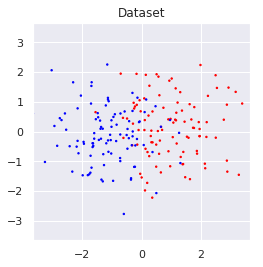

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_dataset(ax, X, y)

# Linear Regression

In [11]:
lm = LinearRegression()

## Integral: Points of least confidence

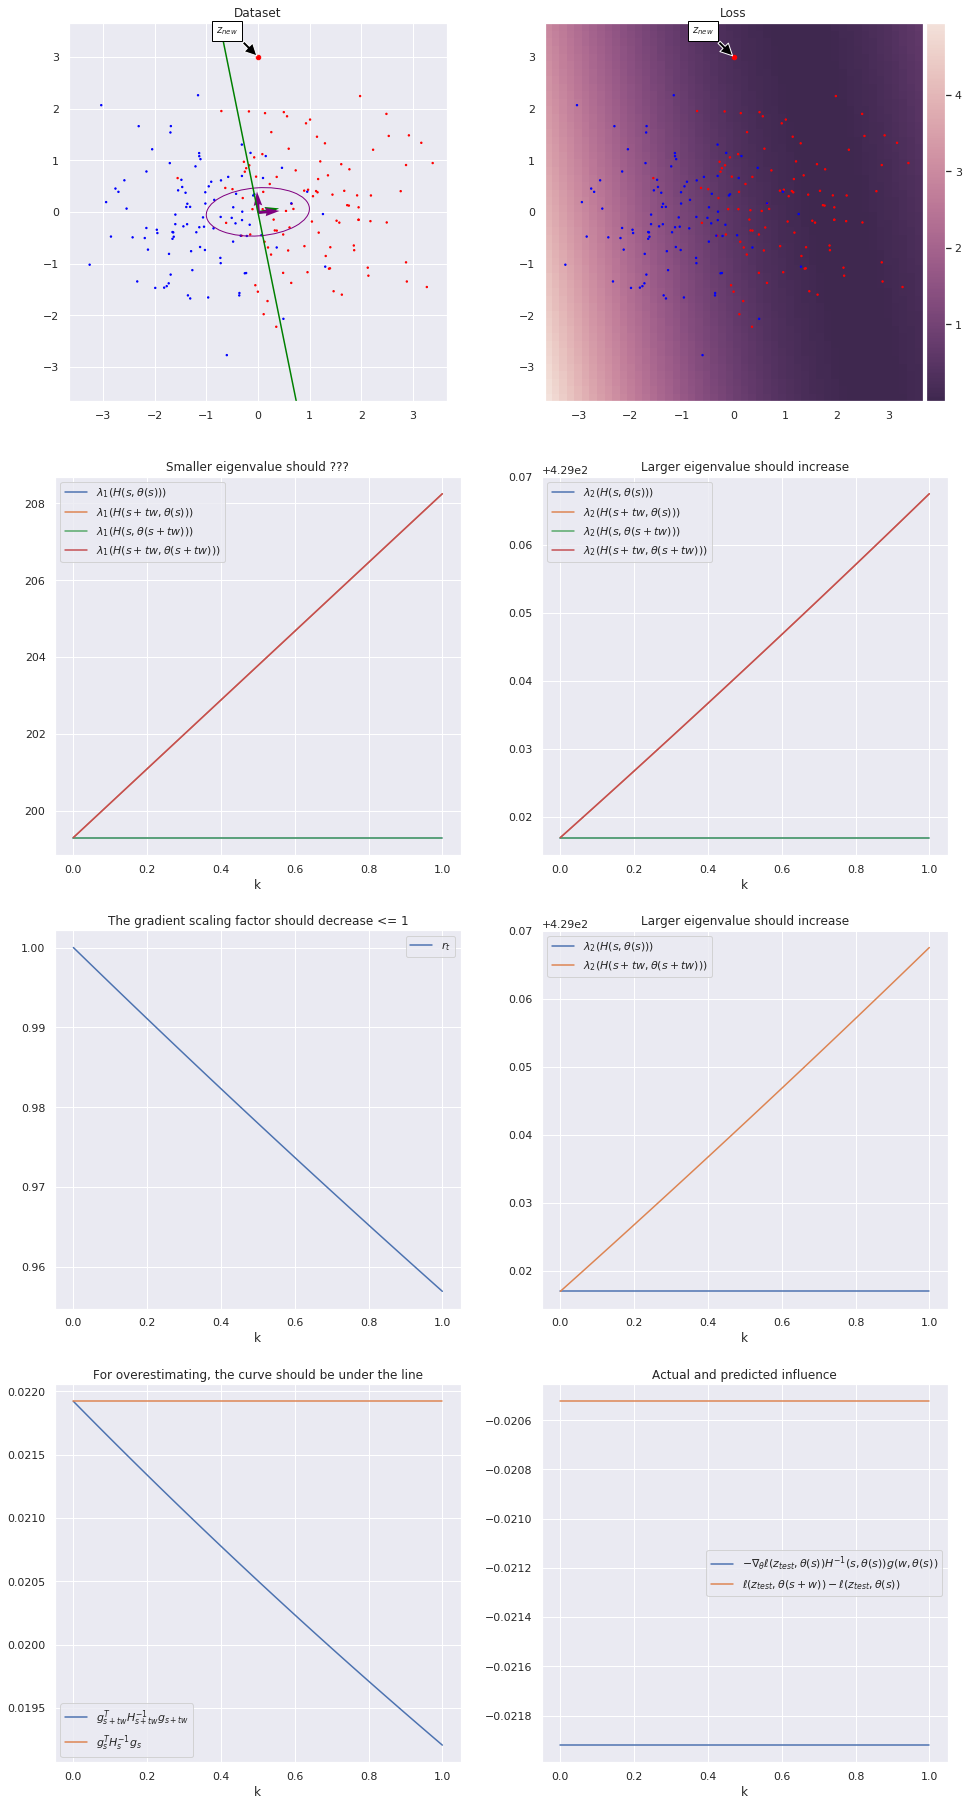

In [12]:
sample_integral(X, y, (np.array([0, 3]), 1),
                row_types=["dataset", "hess_eig", "self_infl_factors", "integrands"],
                lm=lm)

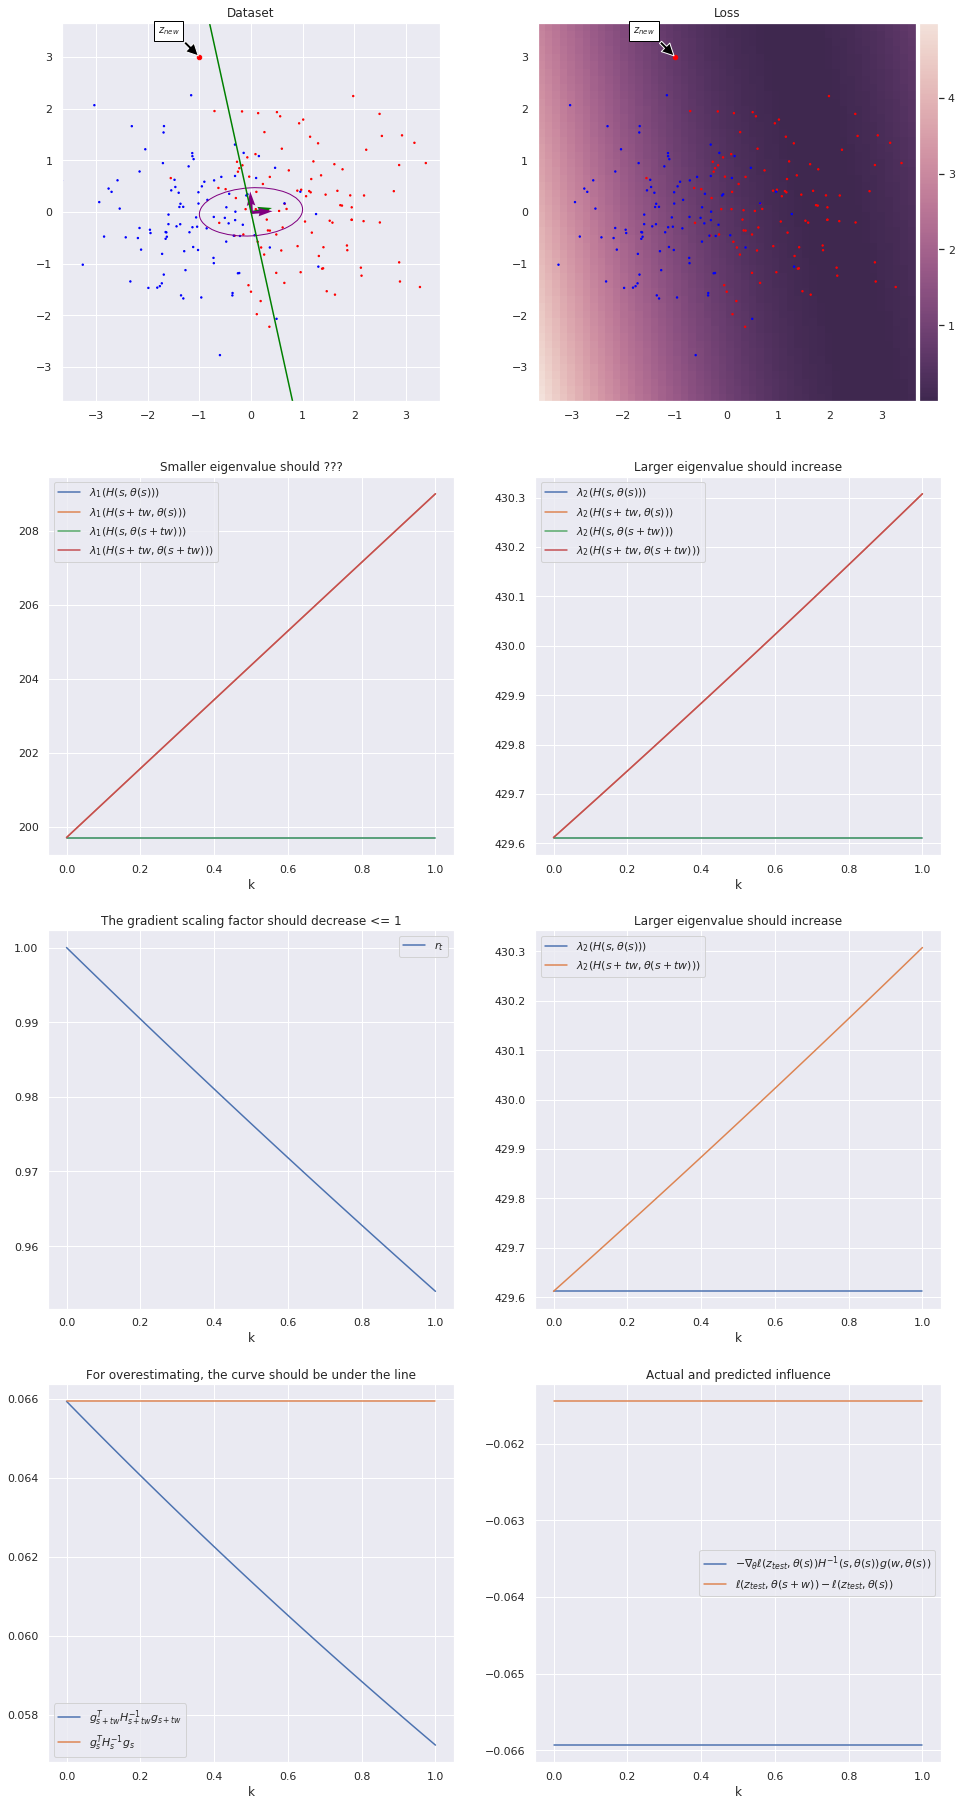

In [13]:
sample_integral(X, y, (np.array([-1, 3]), 1),
                row_types=["dataset", "hess_eig", "self_infl_factors", "integrands"],
                lm=lm)

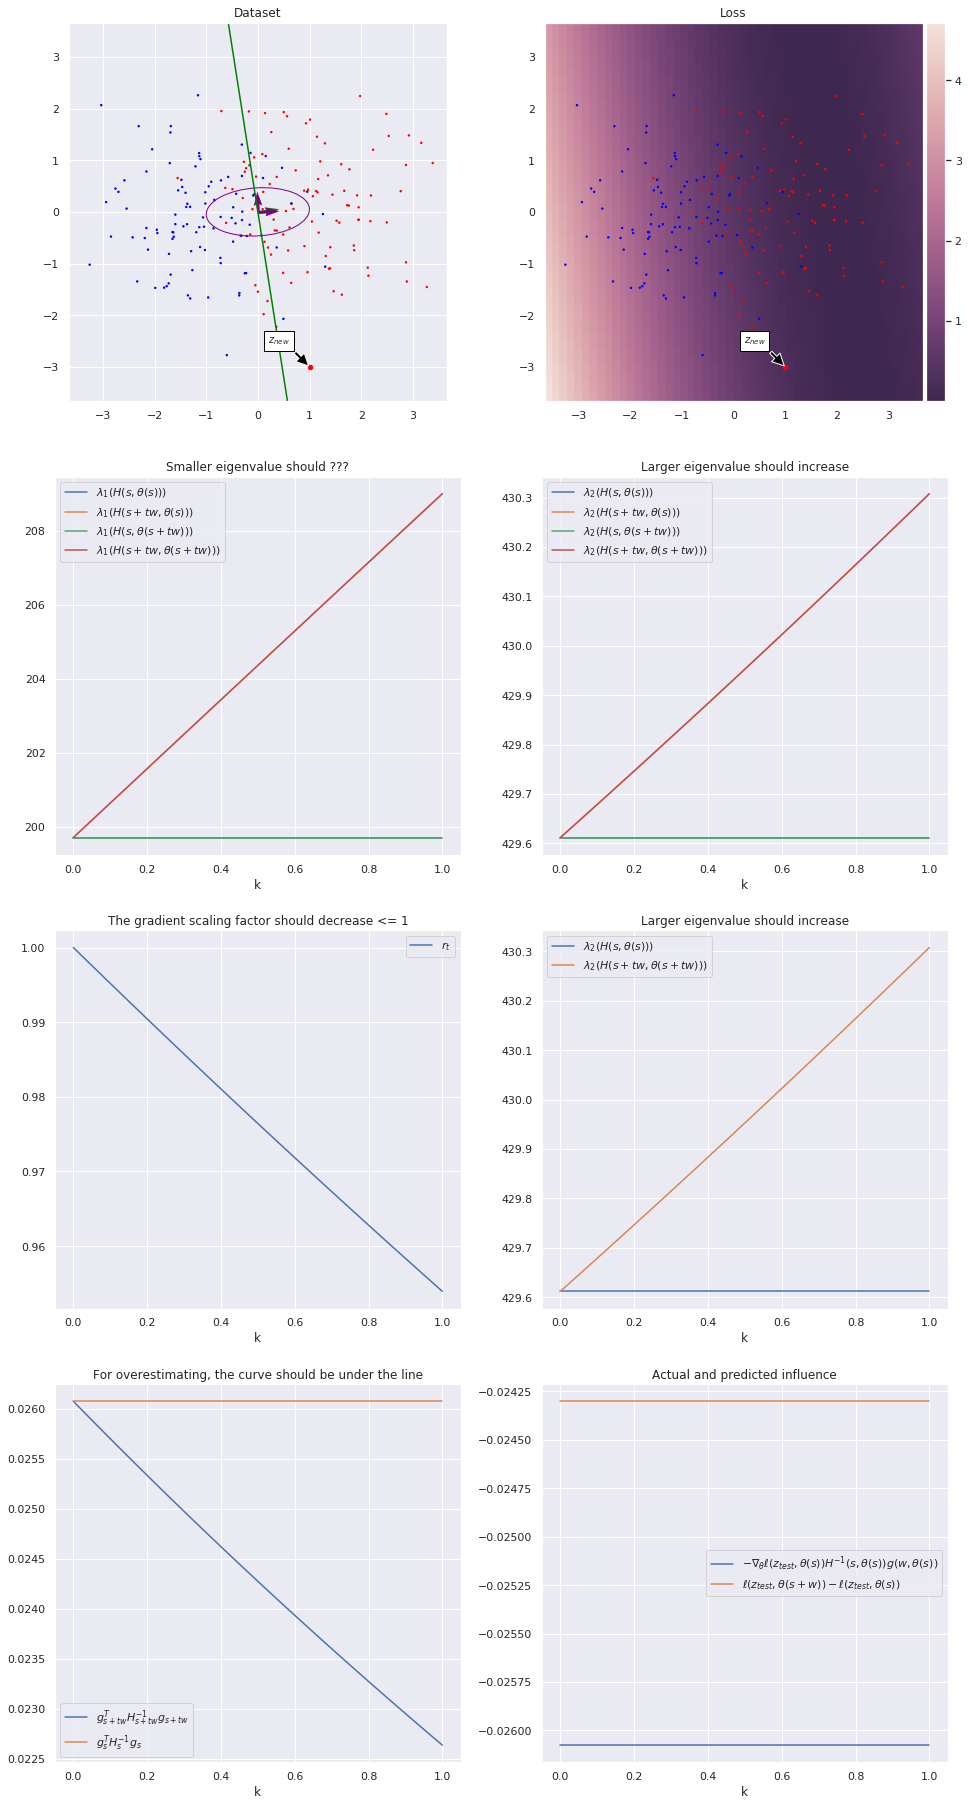

In [14]:
sample_integral(X, y, (np.array([1, -3]), 1),
                row_types=["dataset", "hess_eig", "self_infl_factors", "integrands"],
                lm=lm)

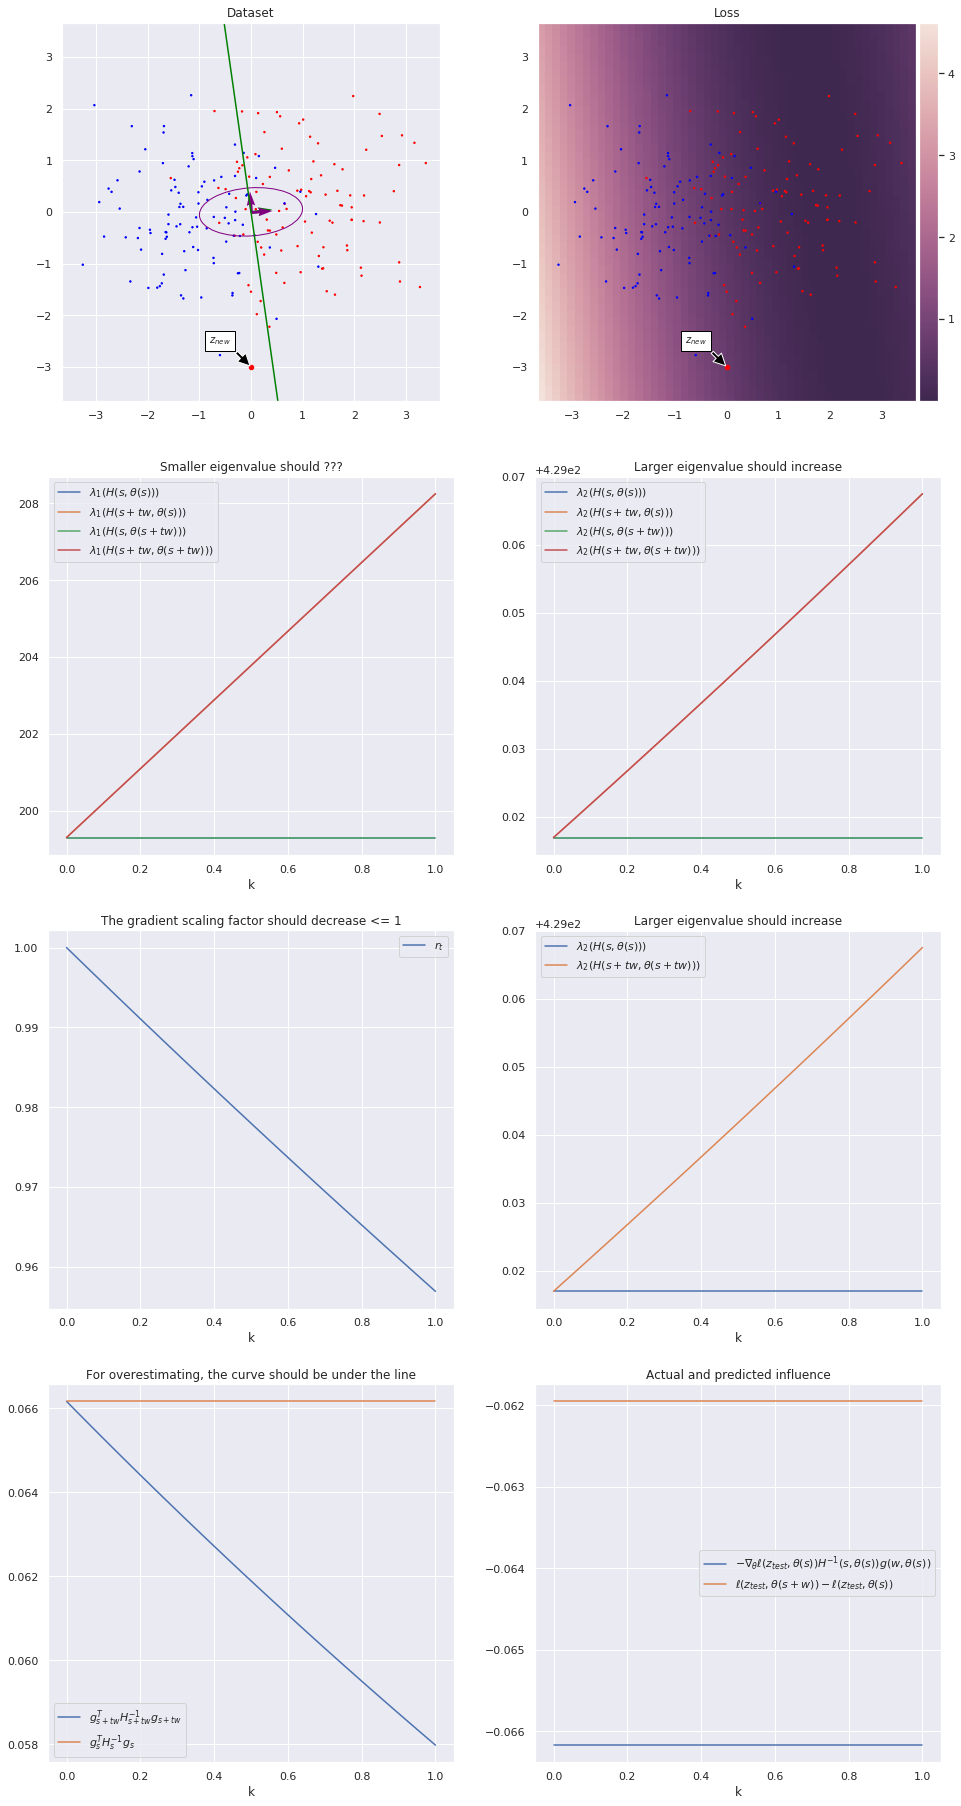

In [15]:
sample_integral(X, y, (np.array([0, -3]), 1),
                row_types=["dataset", "hess_eig", "self_infl_factors", "integrands"],
                lm=lm)

## Integral: Far out points

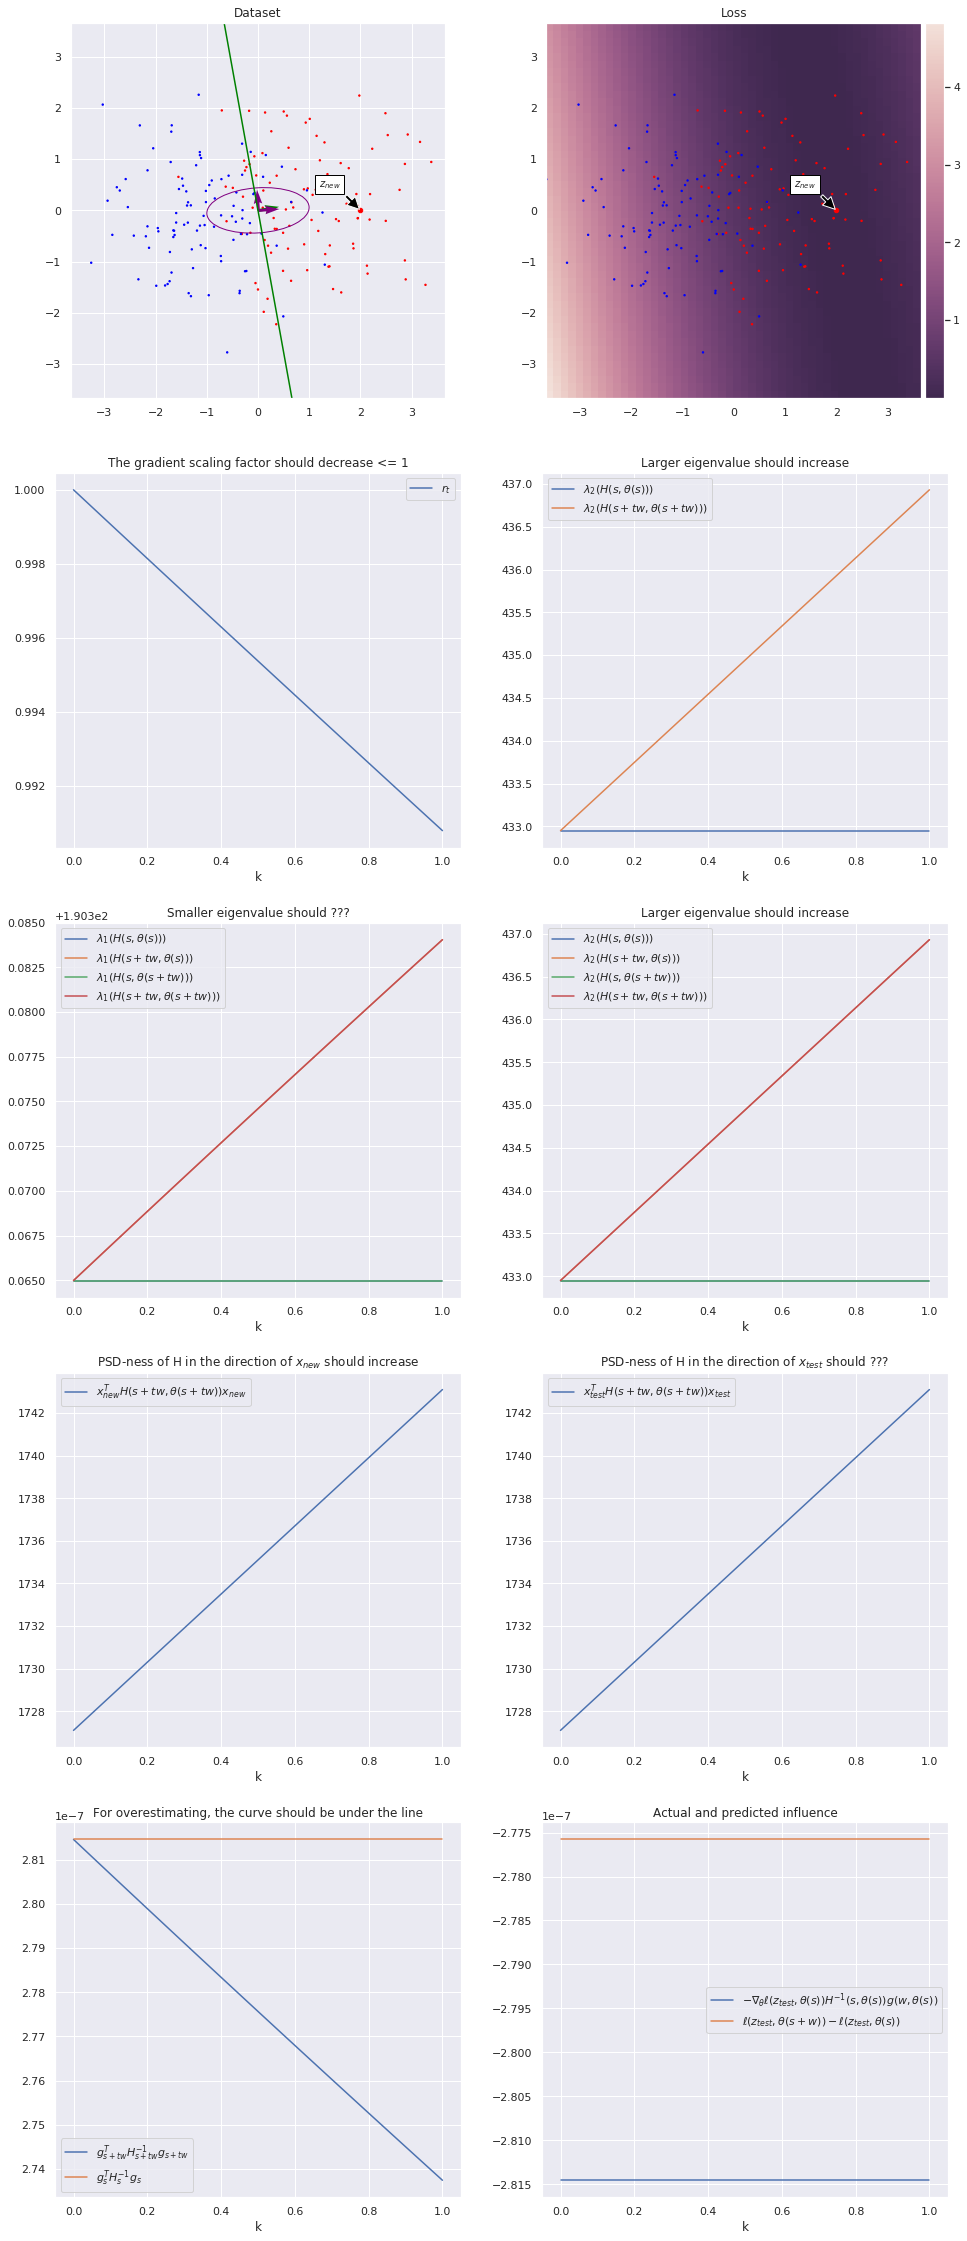

In [16]:
# Affirming
sample_integral(X, y, (np.array([2, 0]), 1),
                row_types=["dataset", "self_infl_factors", "hess_eig", "hess_prod", "integrands"],
                lm=lm)

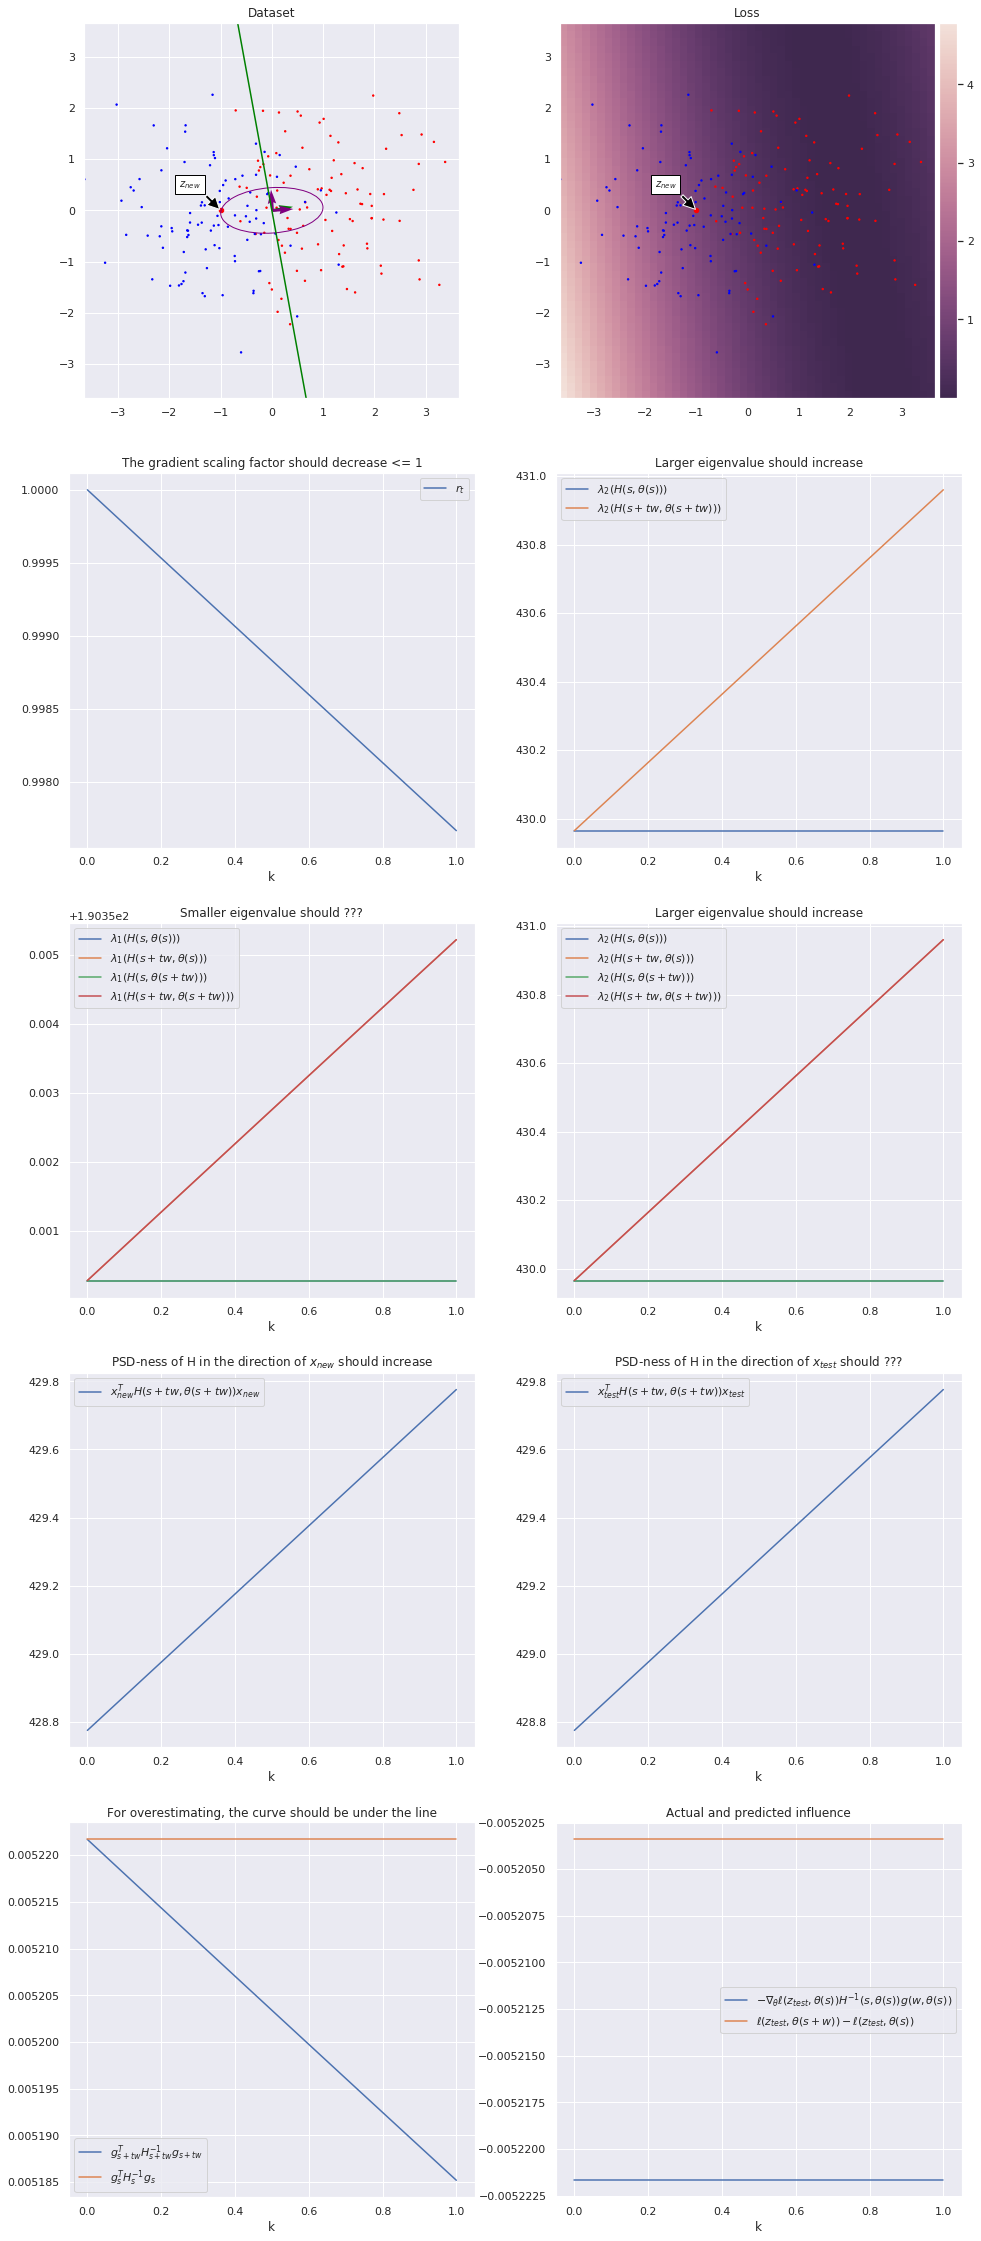

In [17]:
# Confusing
sample_integral(X, y, (np.array([-1, 0]), 1),
                row_types=["dataset", "self_infl_factors", "hess_eig", "hess_prod", "integrands"],
                lm=lm)

## Repeats: Points of least confidence

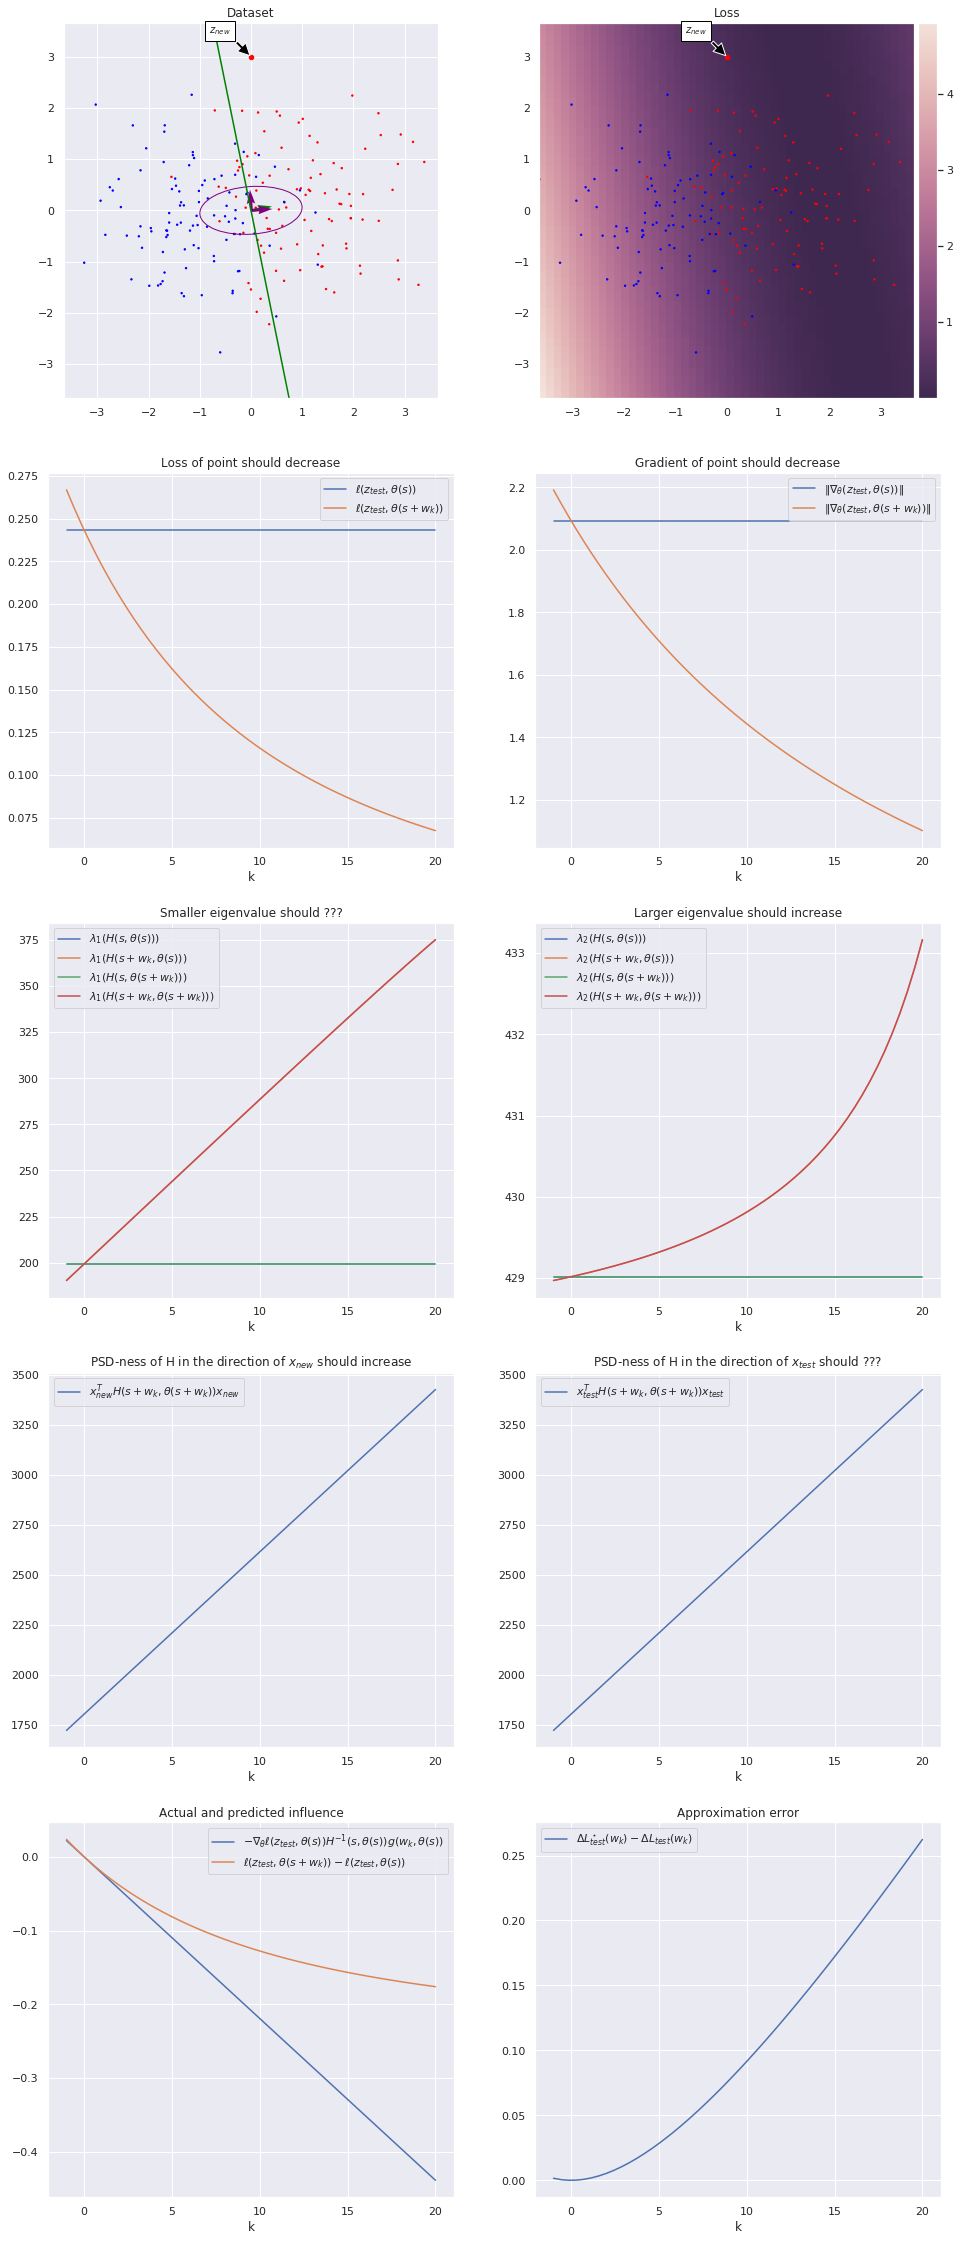

In [18]:
sample_repeats(X, y, (np.array([0, 3]), 1),
               lm=lm)

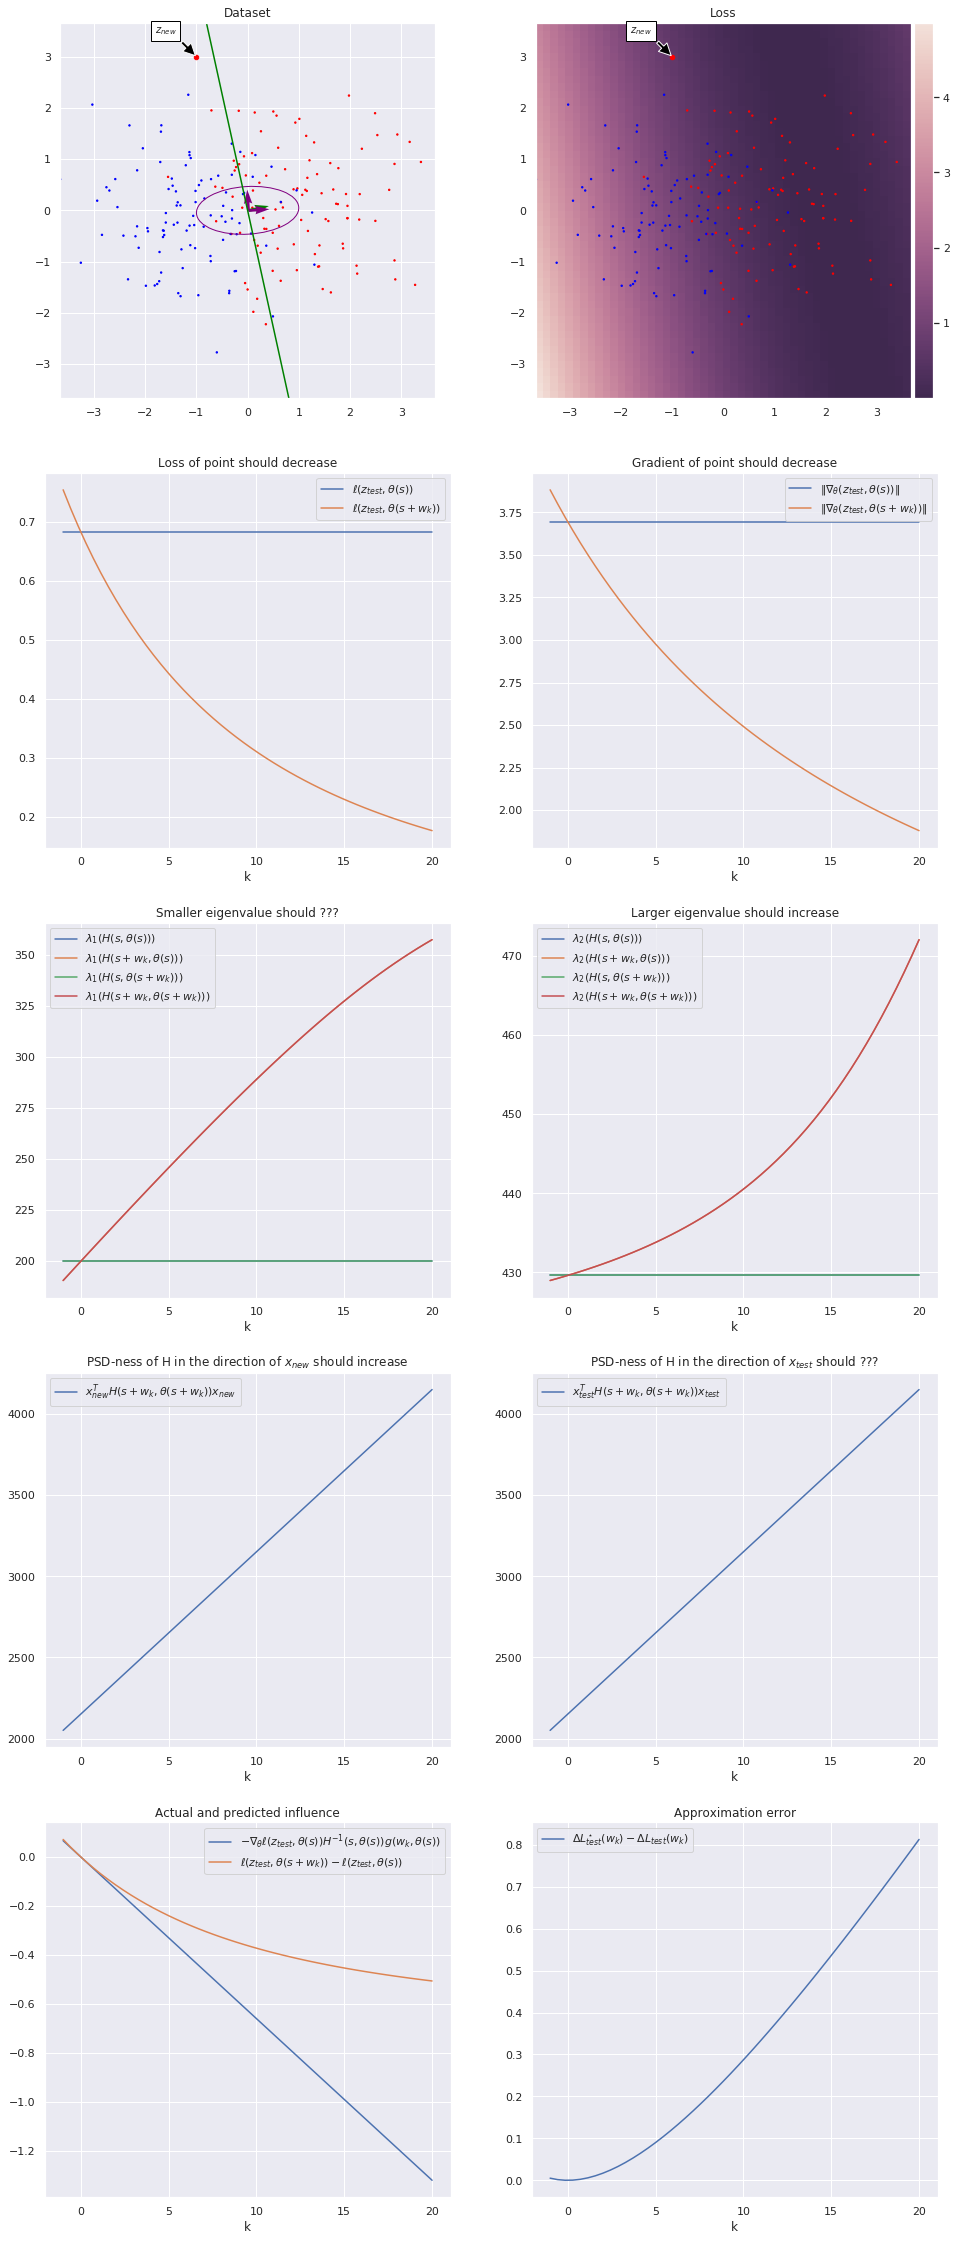

In [19]:
sample_repeats(X, y, (np.array([-1, 3]), 1),
               lm=lm)

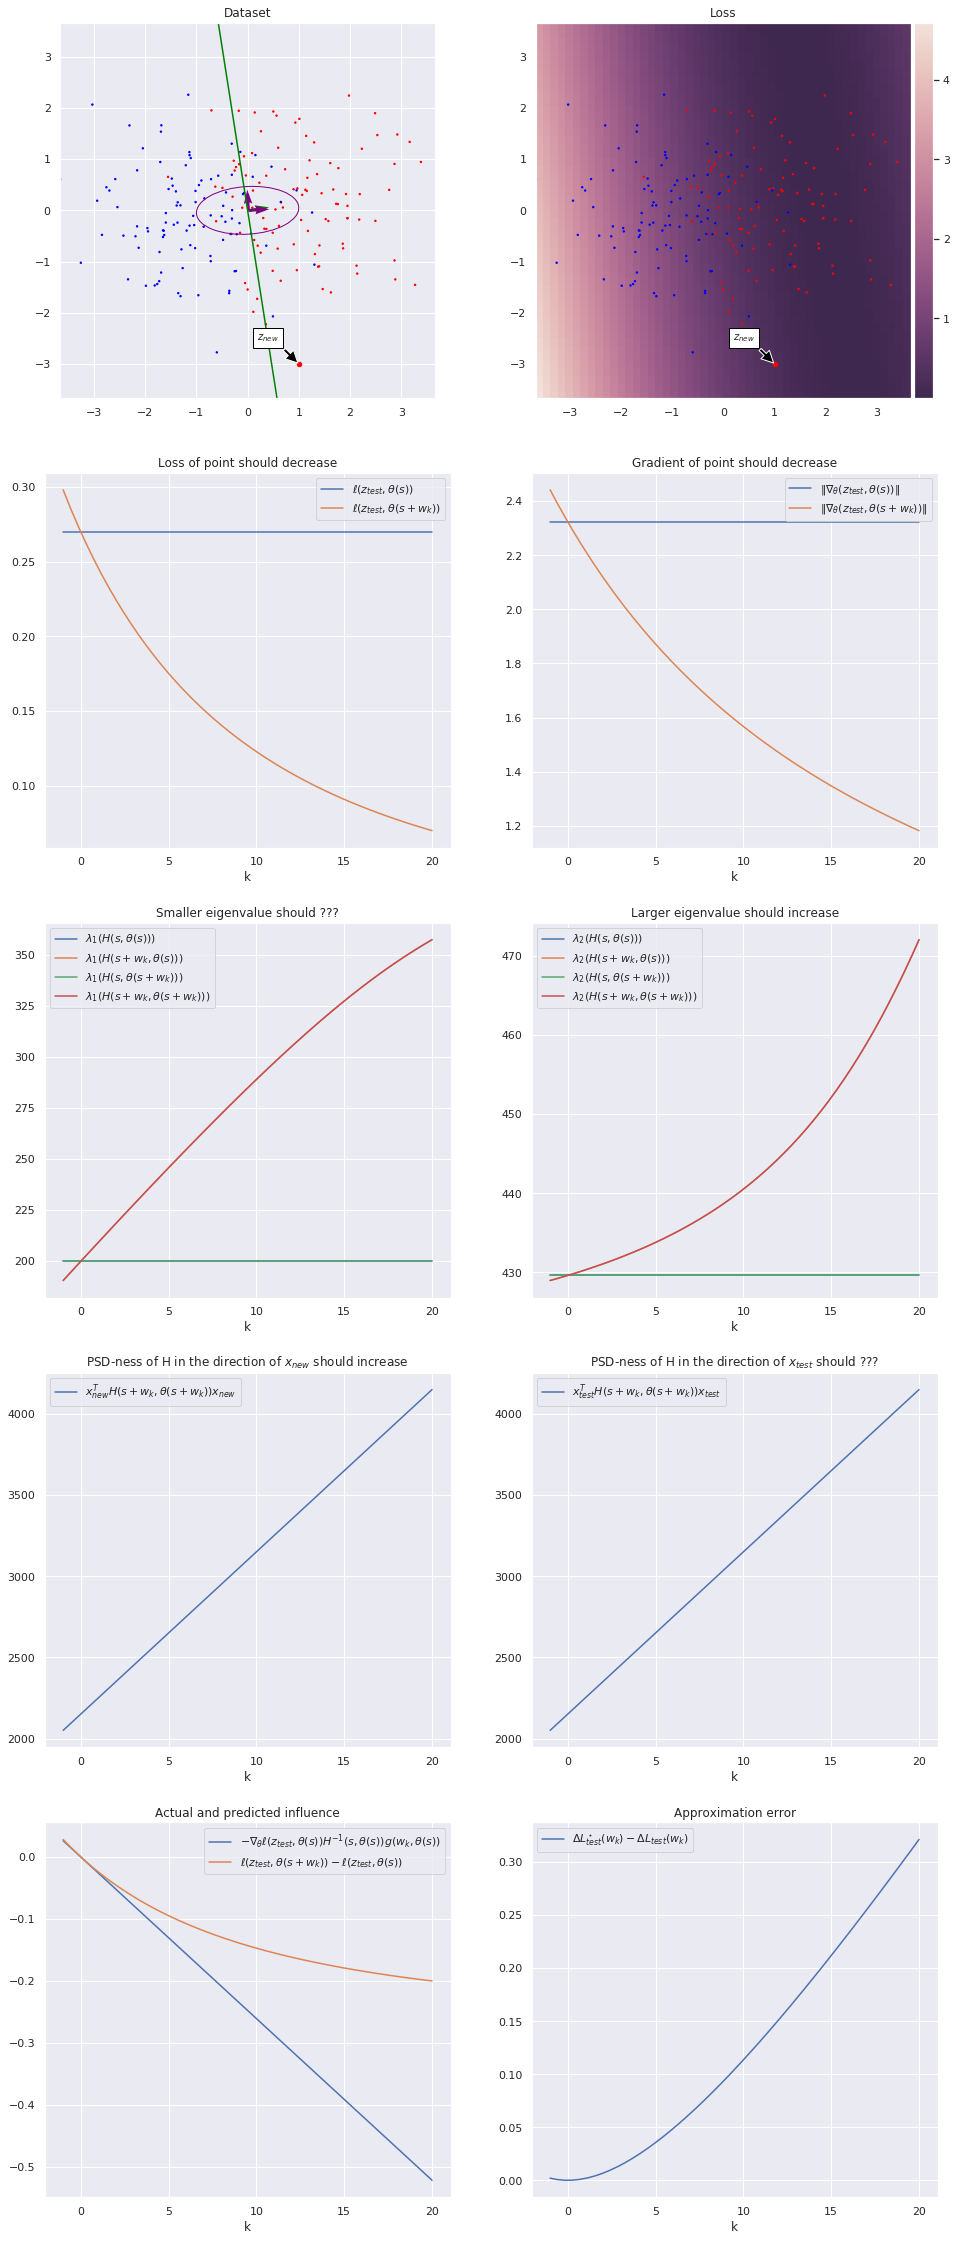

In [20]:
sample_repeats(X, y, (np.array([1, -3]), 1),
               lm=lm)

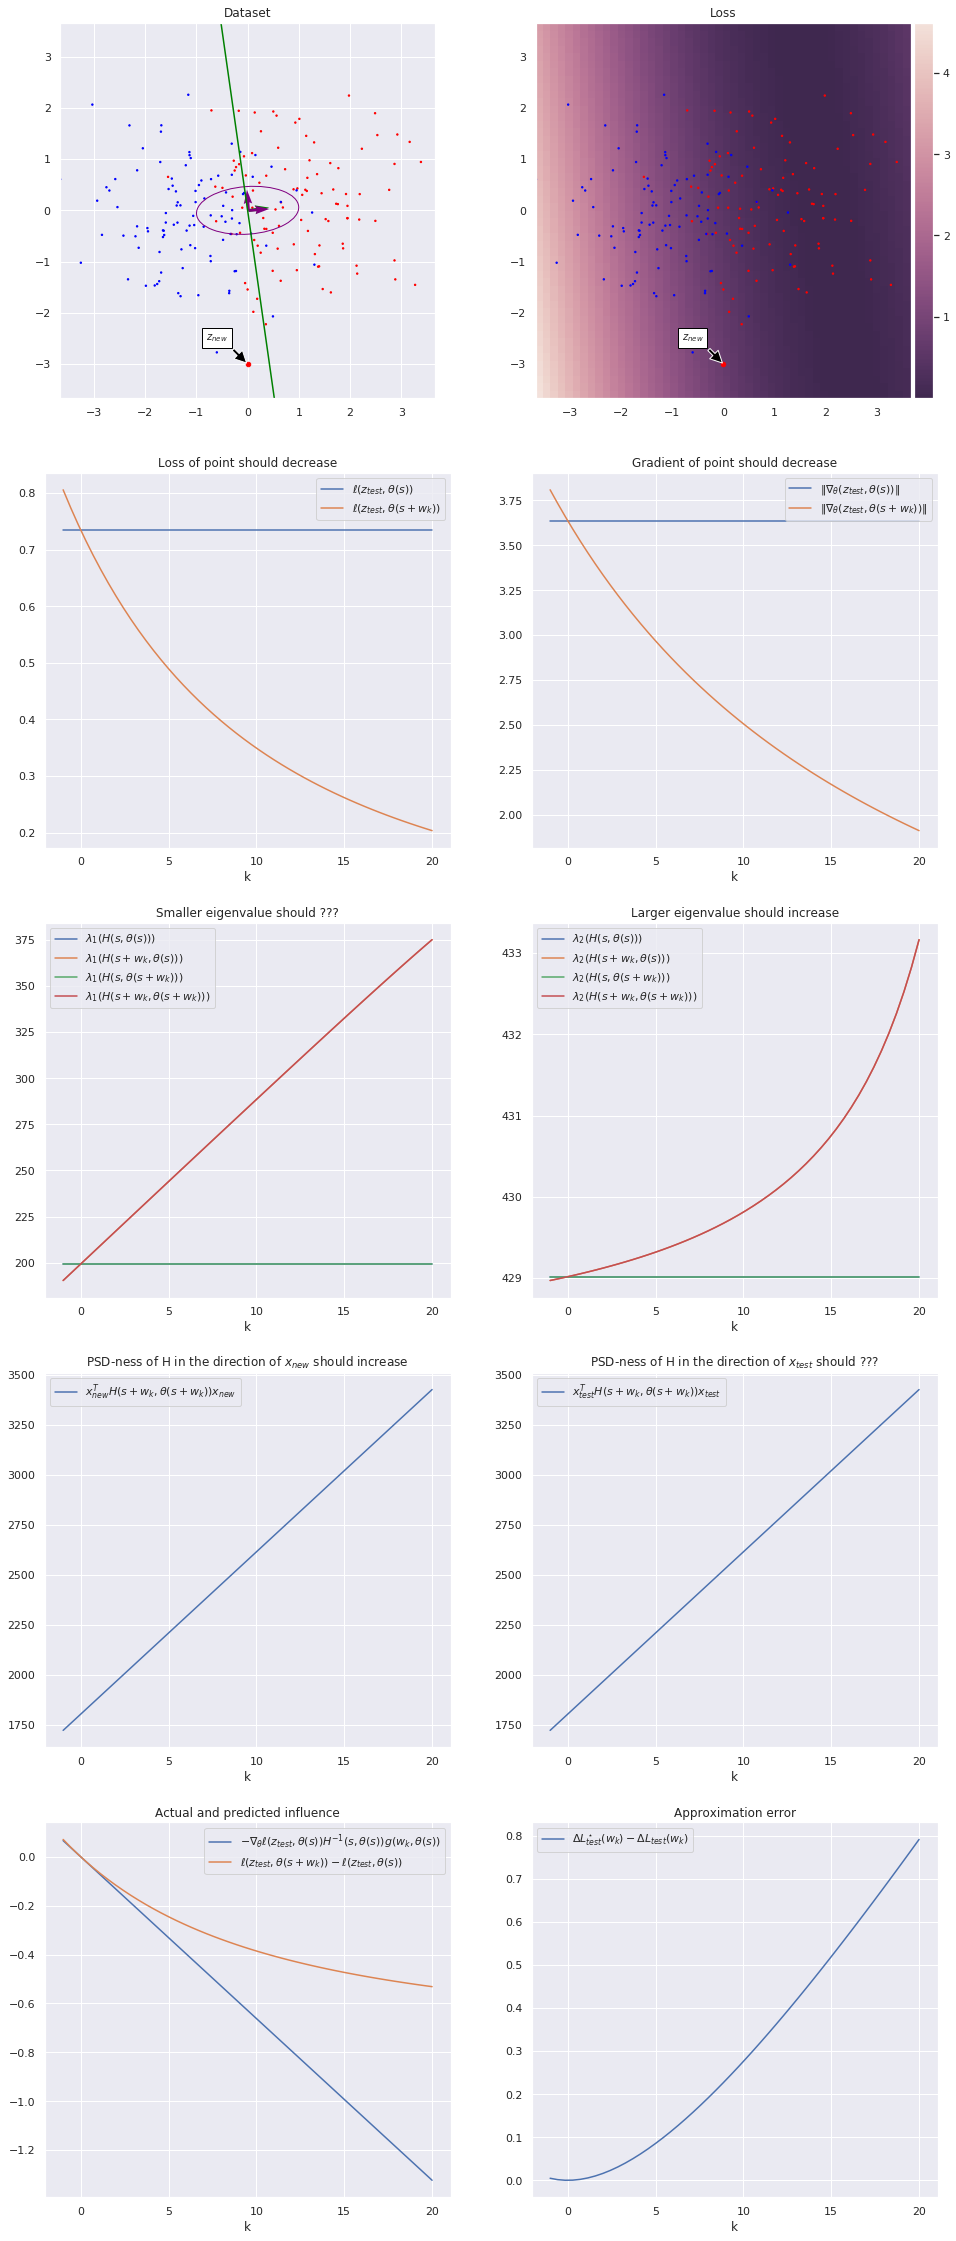

In [21]:
sample_repeats(X, y, (np.array([0, -3]), 1),
               lm=lm)

## Repeats: Far out points

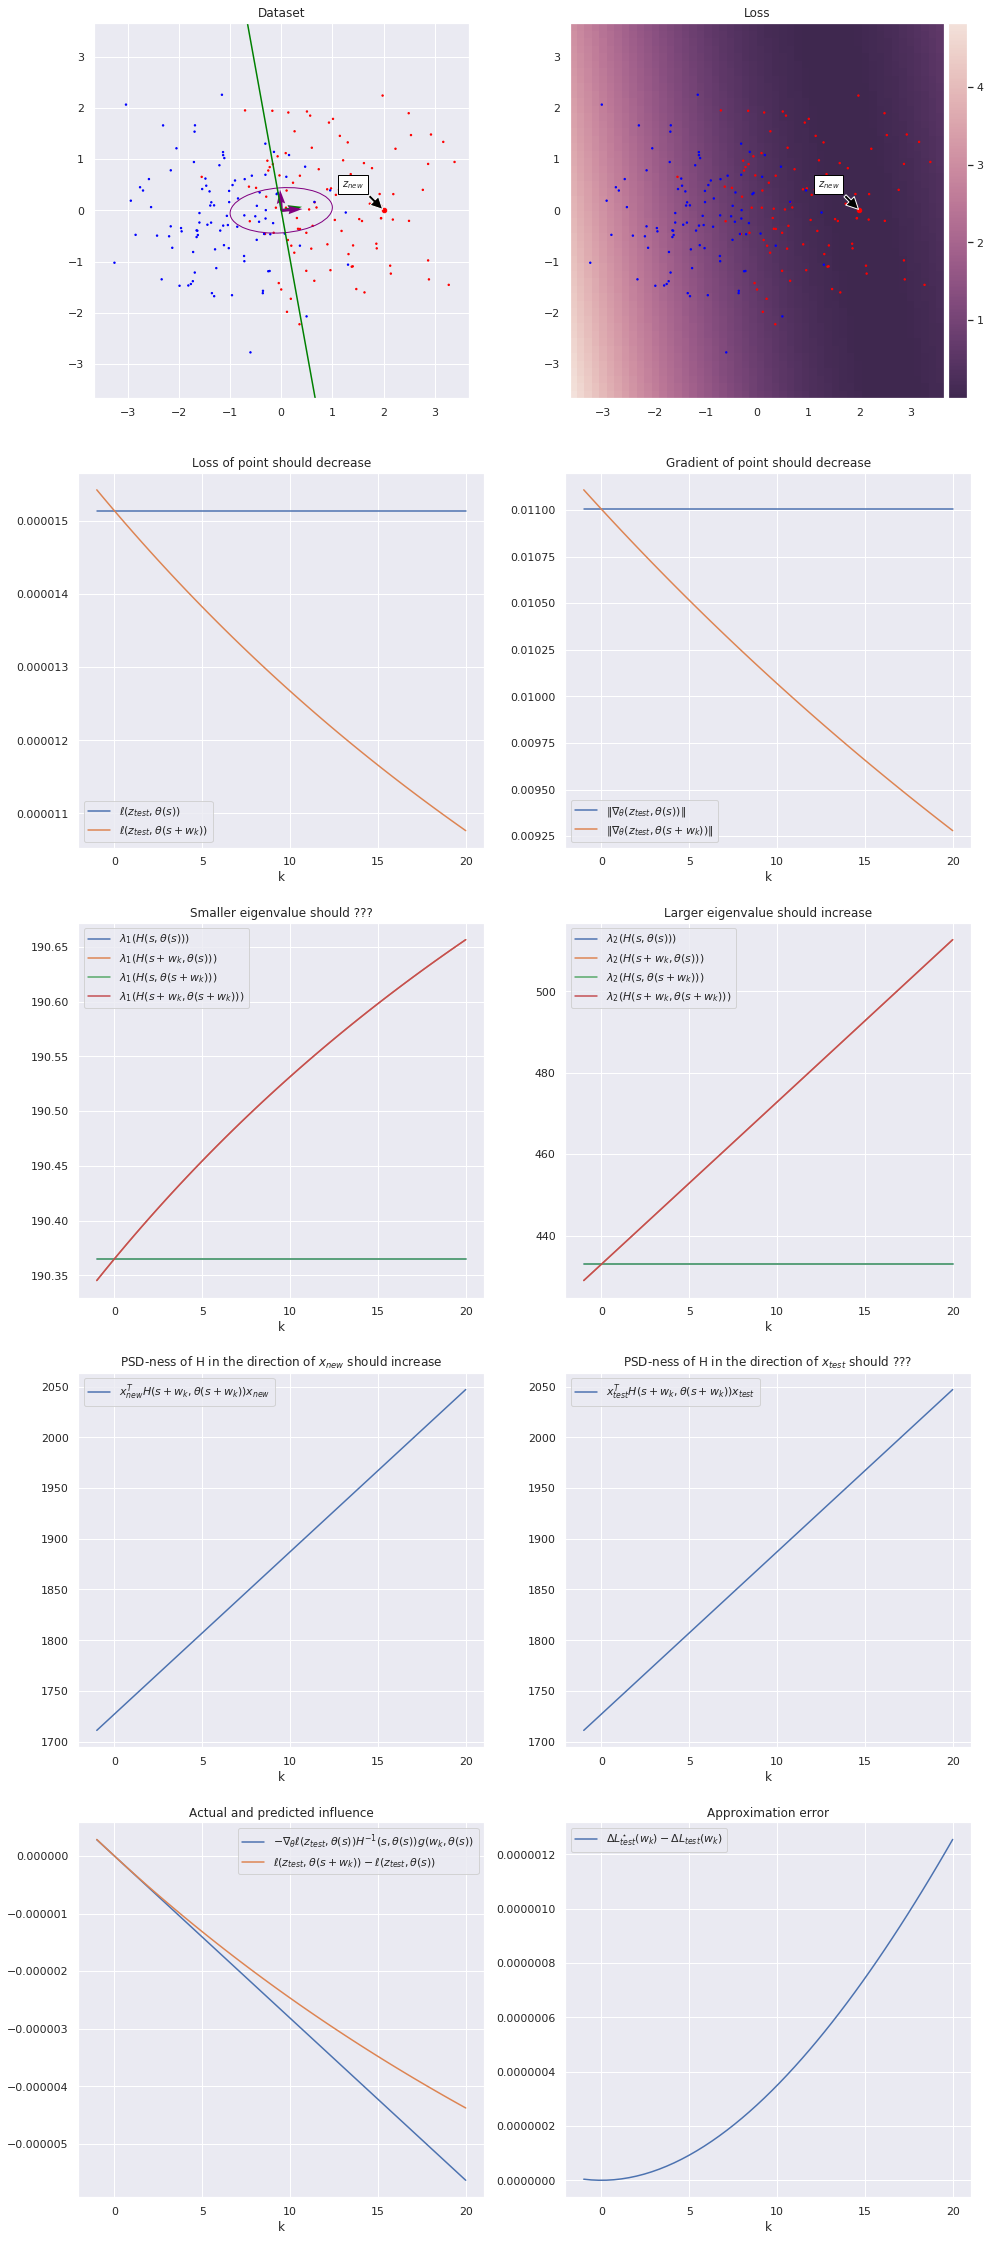

In [22]:
# Affirming
sample_repeats(X, y, (np.array([2, 0]), 1),
               lm=lm)

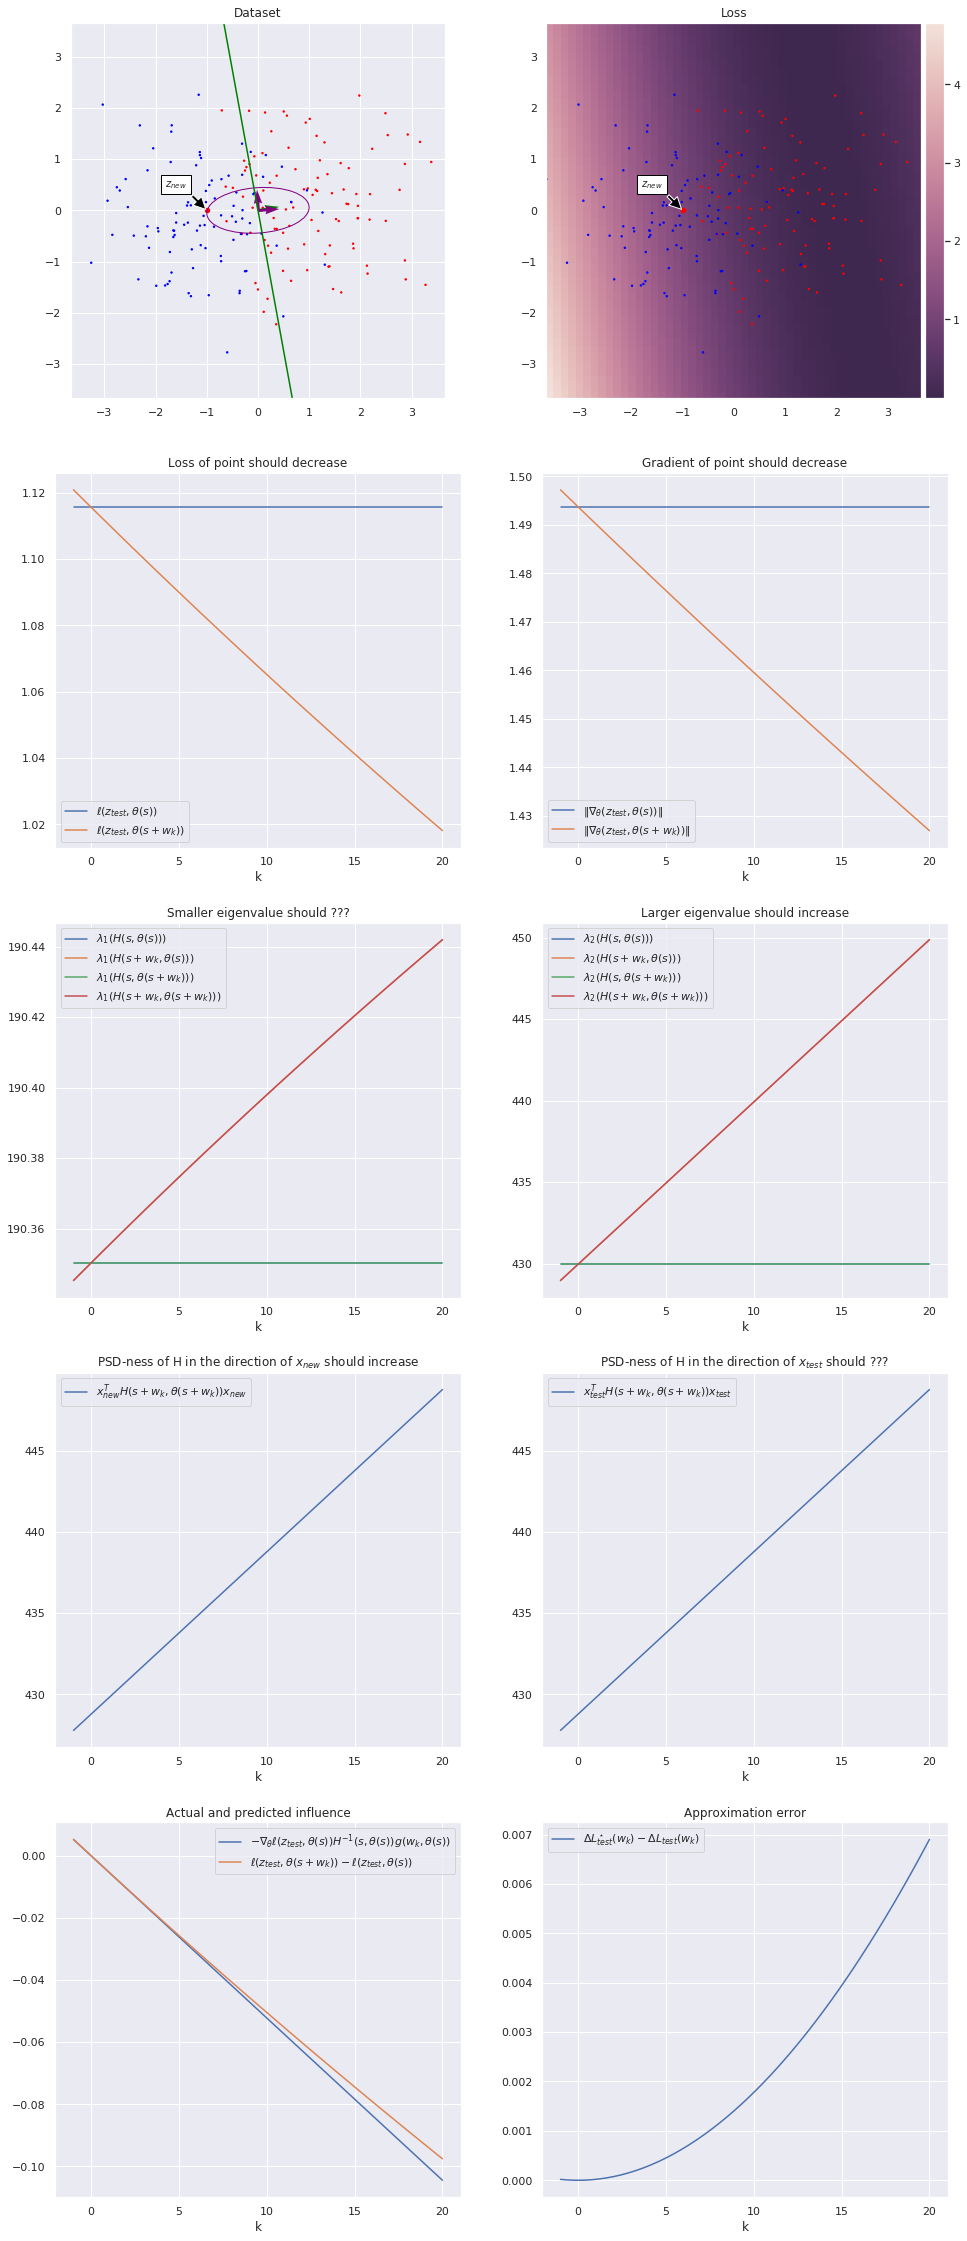

In [23]:
# Confusing
sample_repeats(X, y, (np.array([-1, 0]), 1),
               lm=lm)

# Logistic Regression

## Integral: Points of least confidence

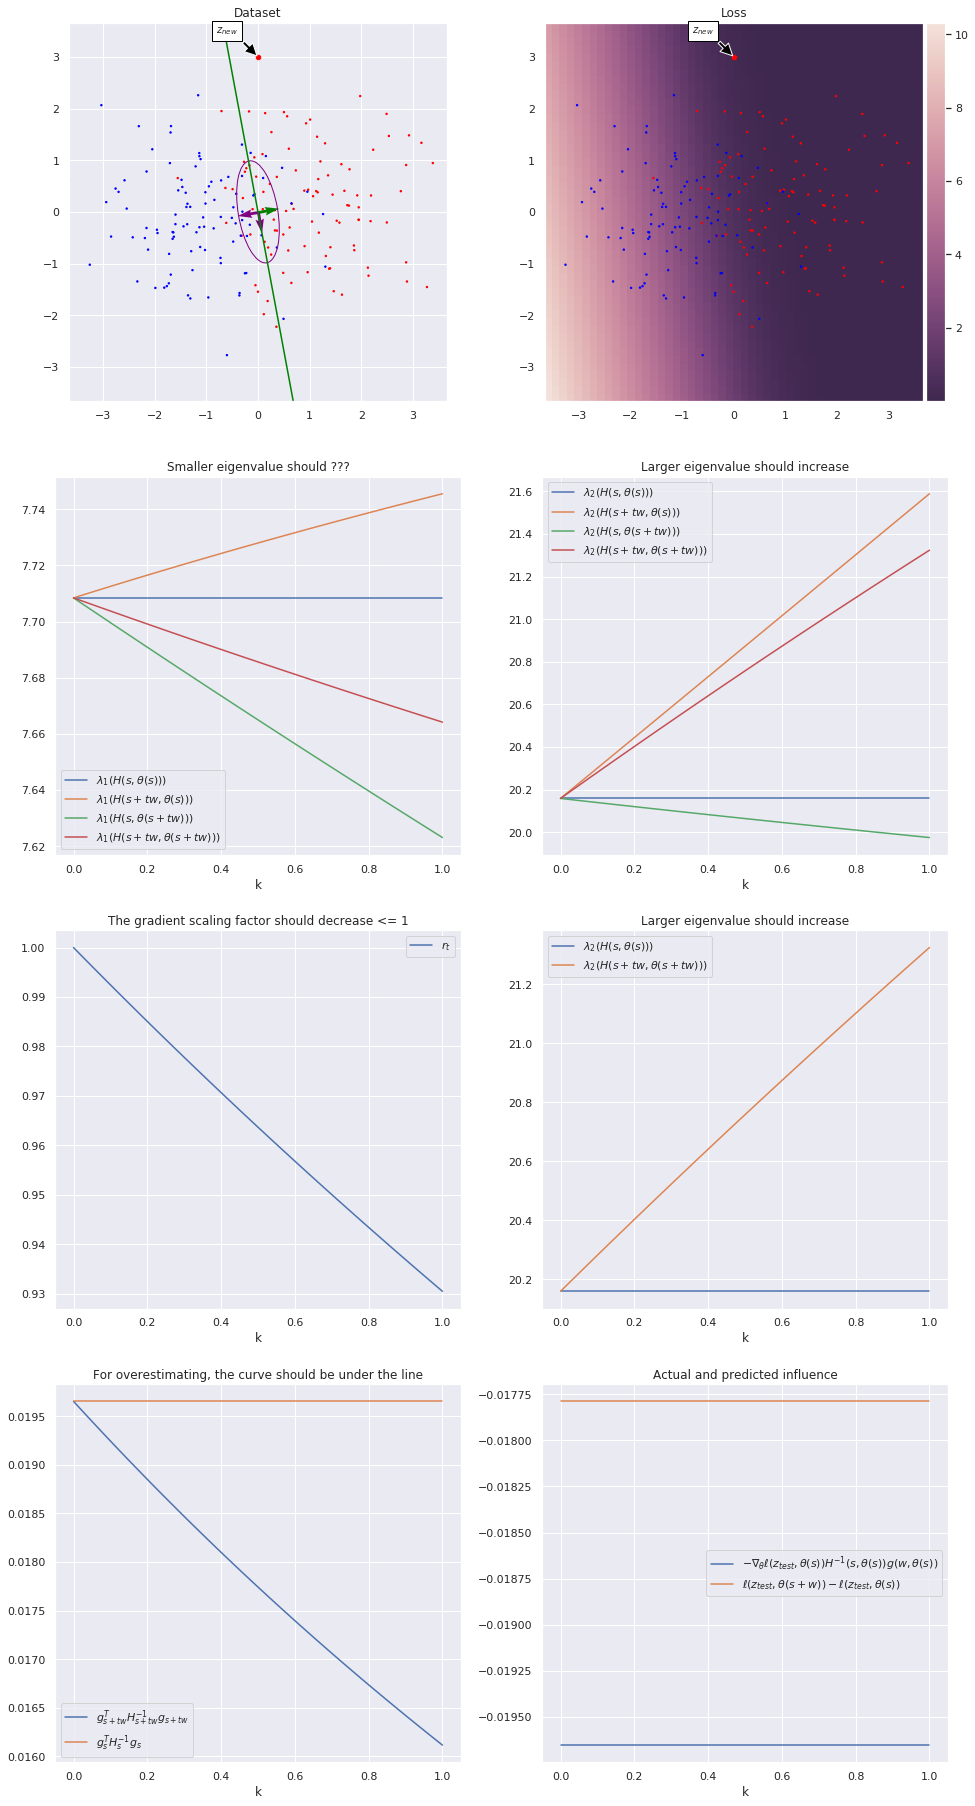

In [24]:
sample_integral(X, y, (np.array([0, 3]), 1),
                row_types=["dataset", "hess_eig", "self_infl_factors", "integrands"])

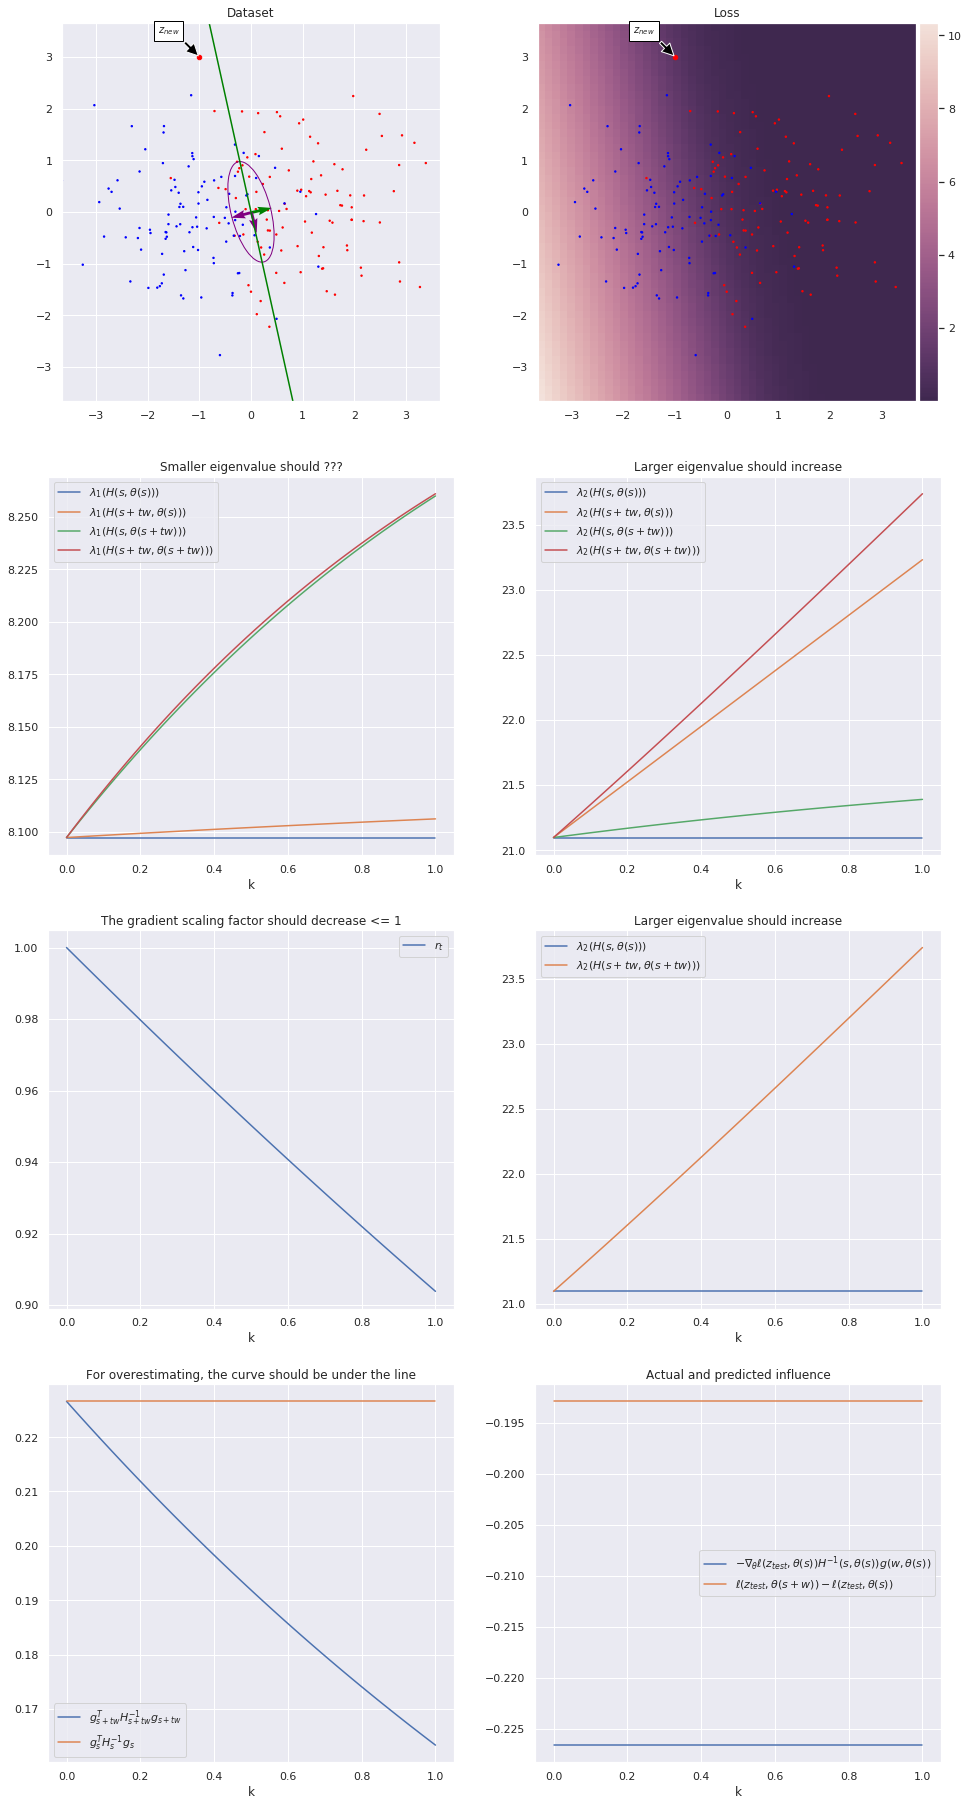

In [25]:
sample_integral(X, y, (np.array([-1, 3]), 1),
               row_types=["dataset", "hess_eig", "self_infl_factors", "integrands"])

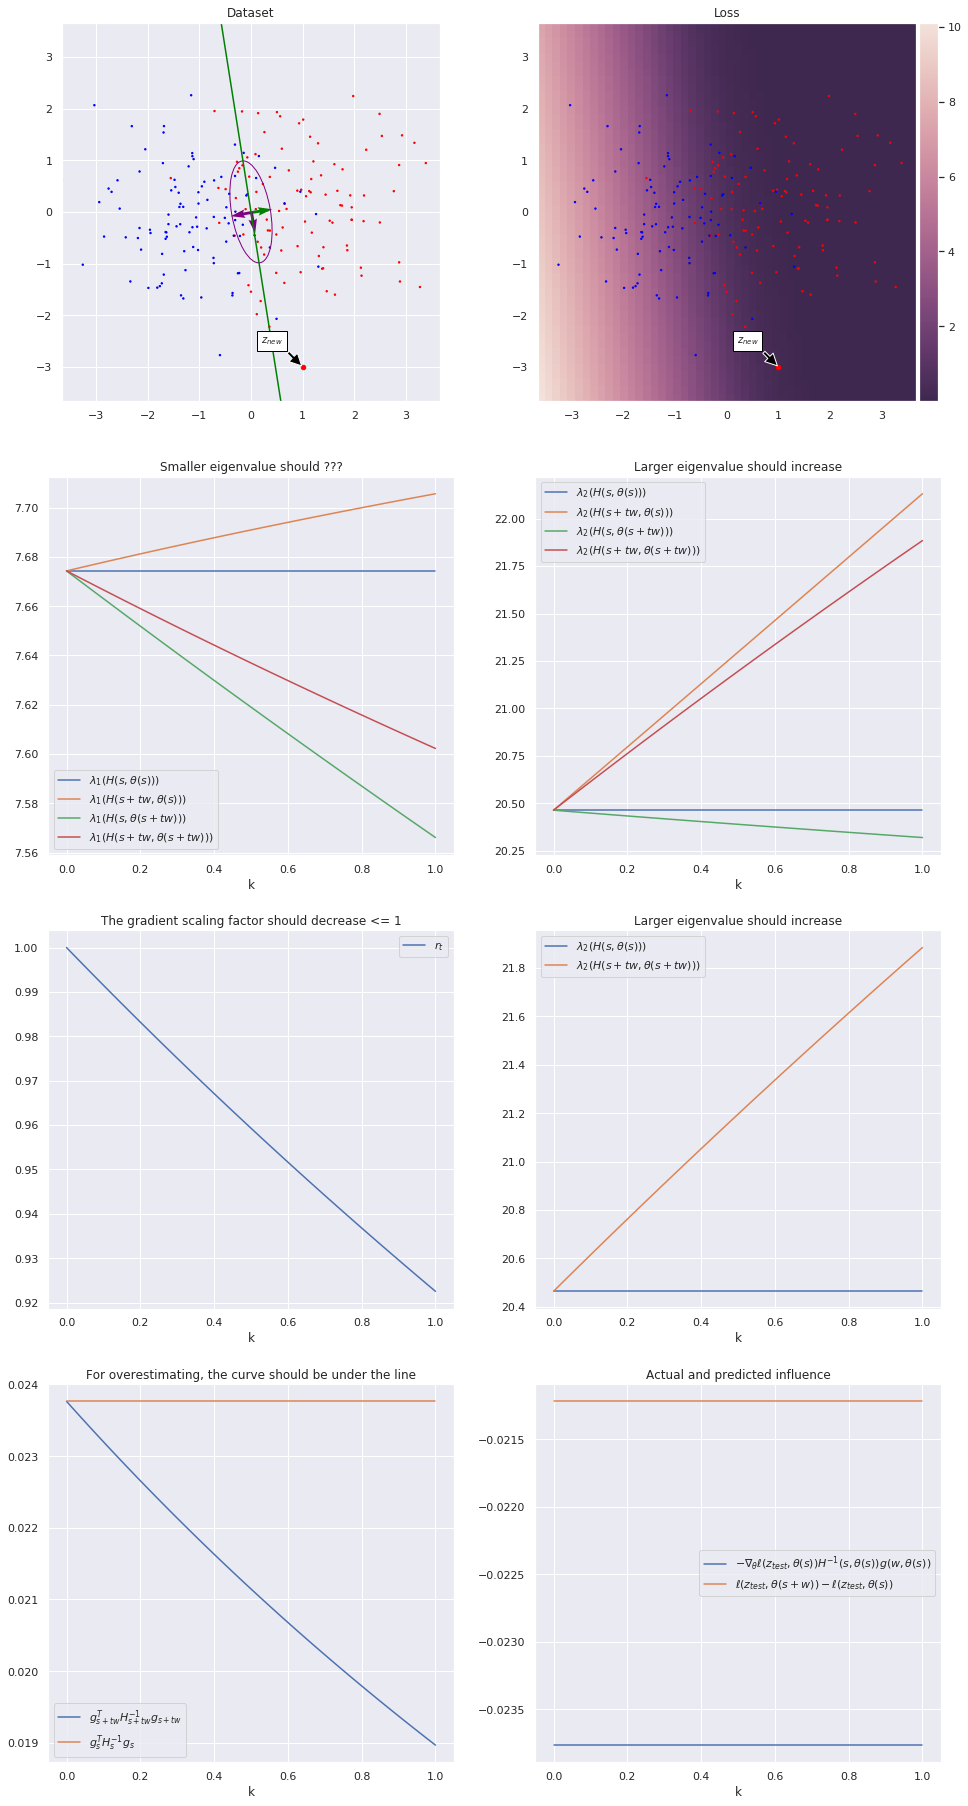

In [26]:
sample_integral(X, y, (np.array([1, -3]), 1),
               row_types=["dataset", "hess_eig", "self_infl_factors", "integrands"])

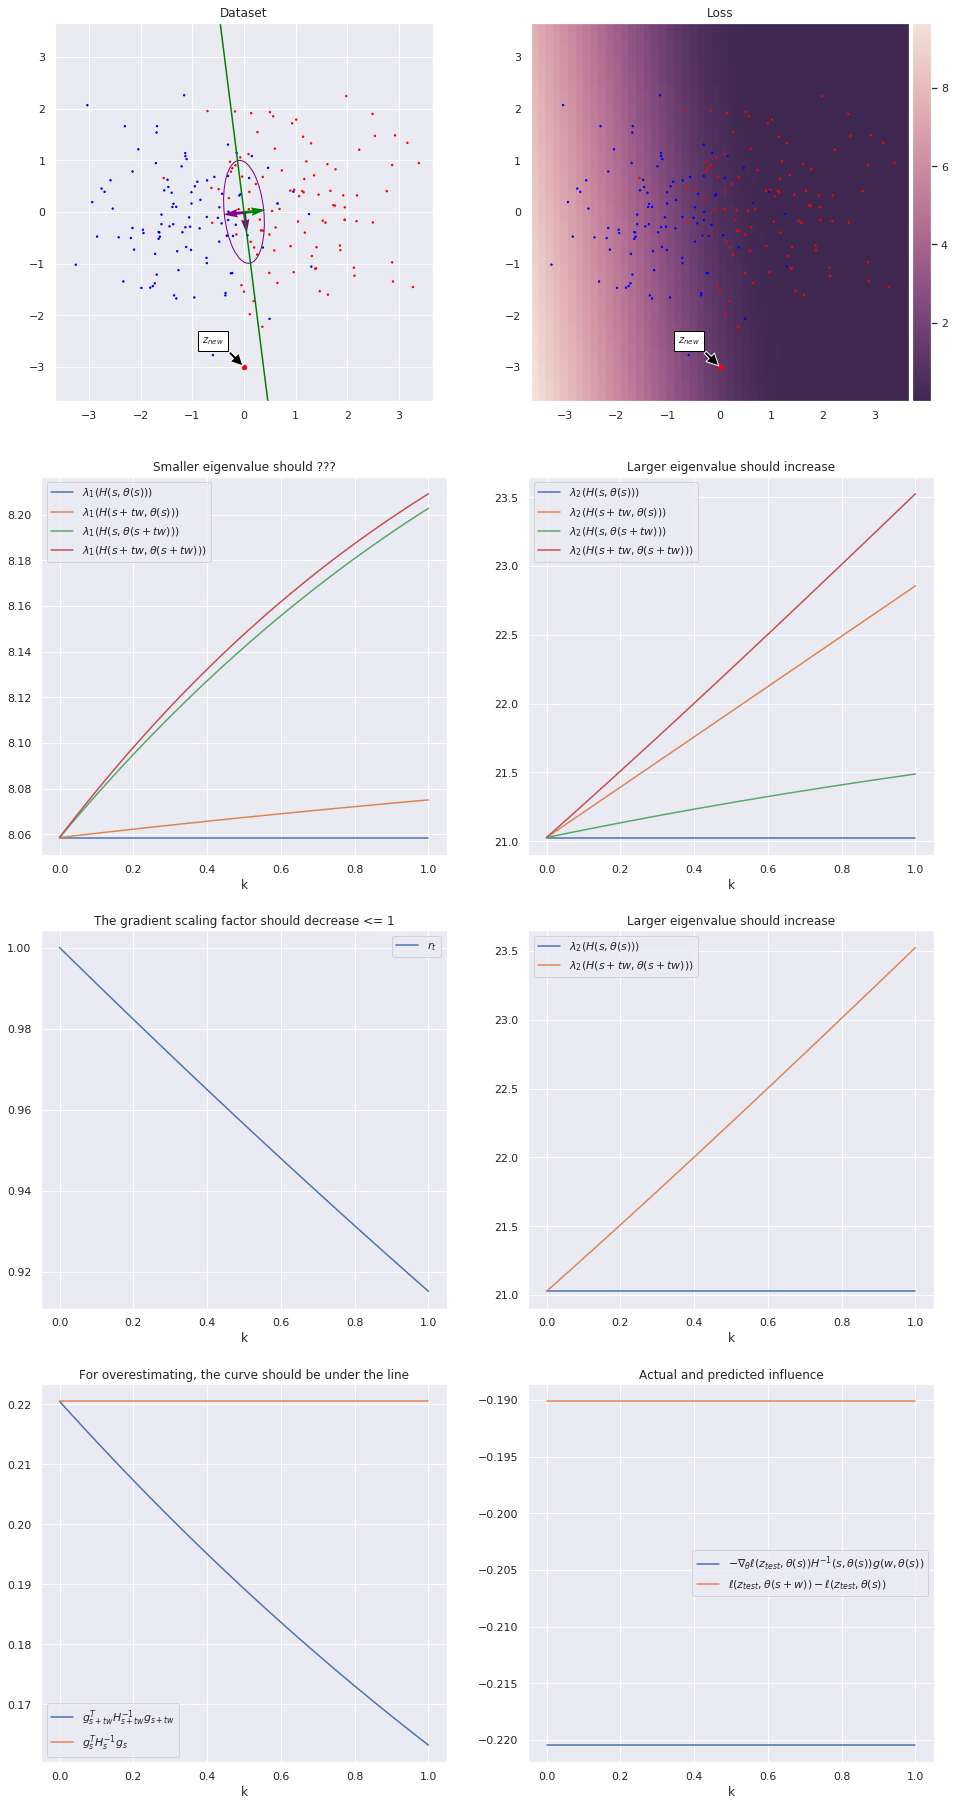

In [27]:
sample_integral(X, y, (np.array([0, -3]), 1),
               row_types=["dataset", "hess_eig", "self_infl_factors", "integrands"])

## Integral: Far out points

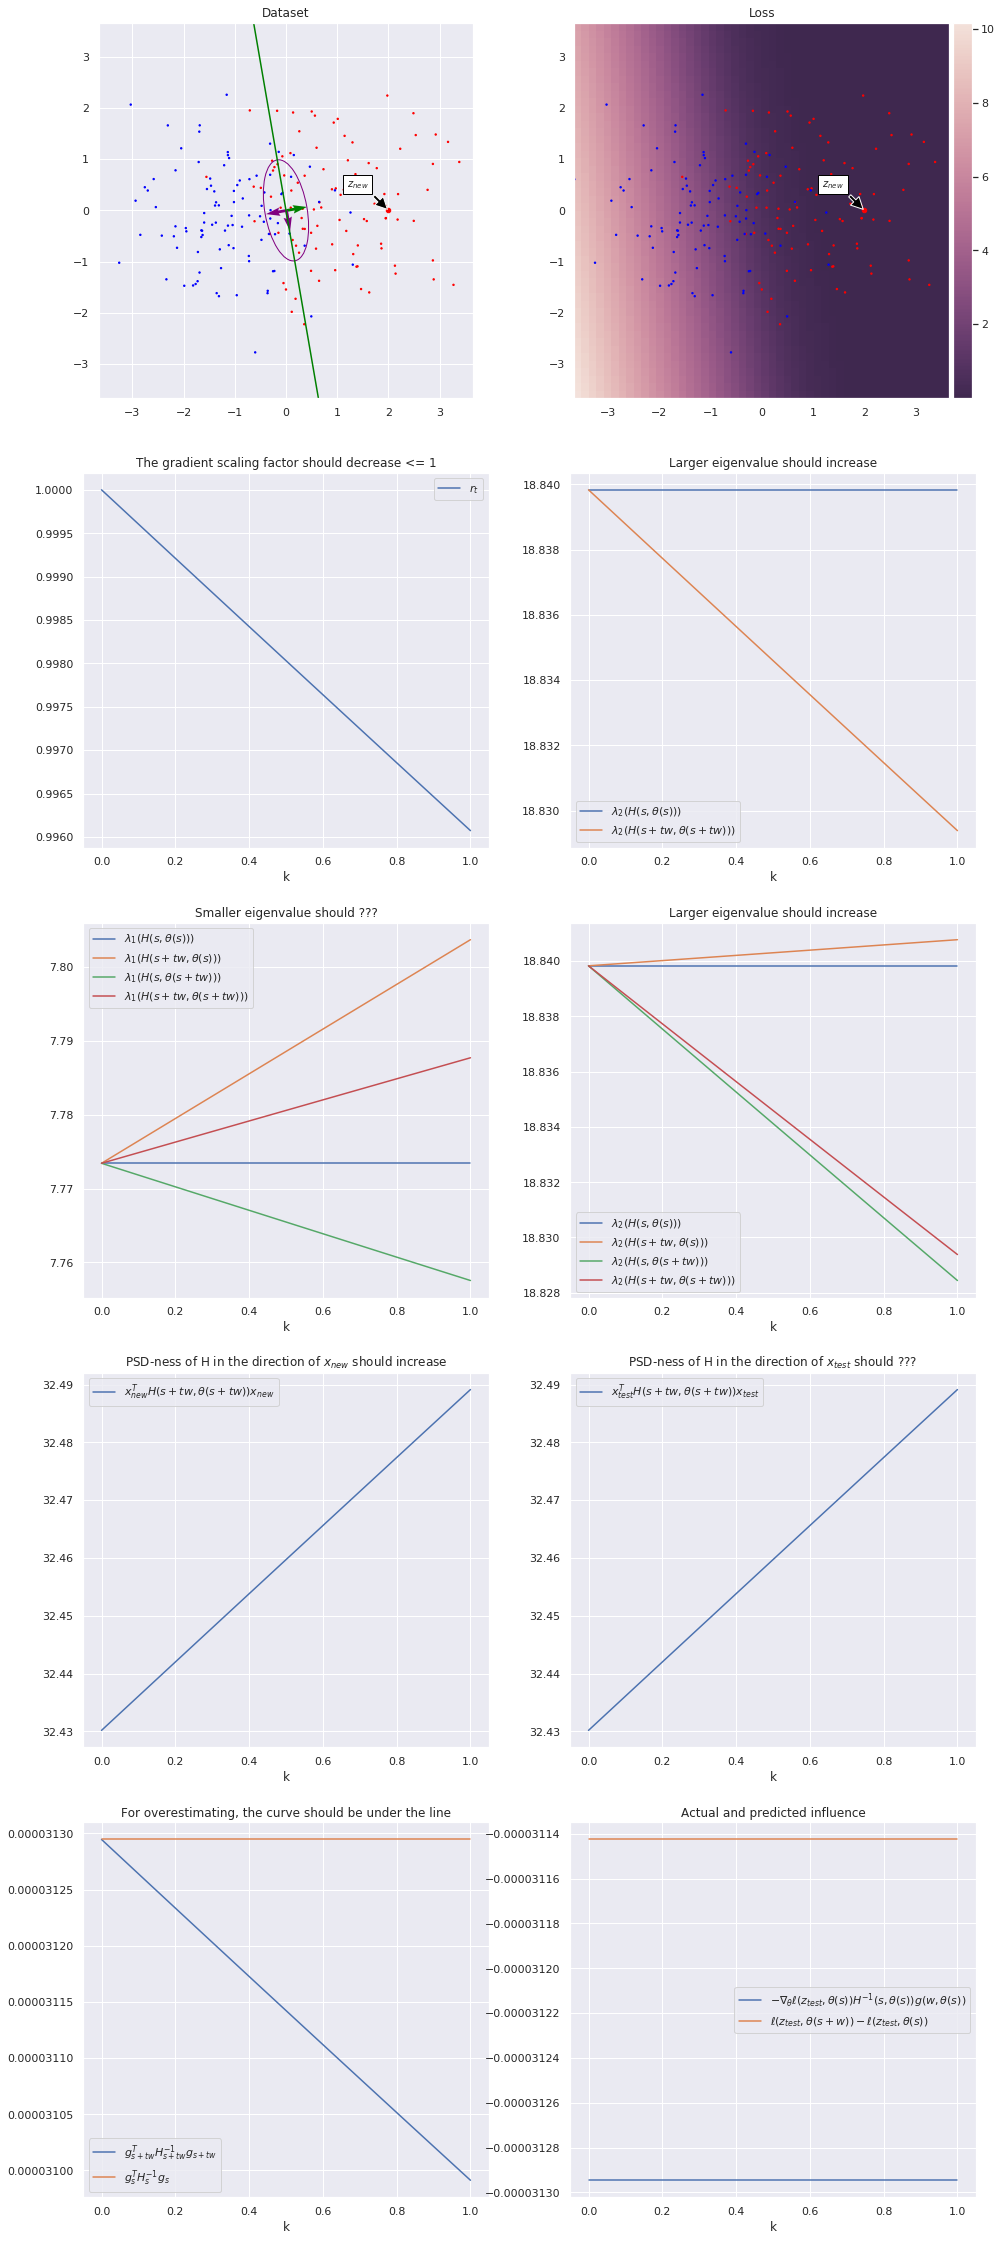

In [28]:
# Affirming
sample_integral(X, y, (np.array([2, 0]), 1),
                row_types=["dataset", "self_infl_factors", "hess_eig", "hess_prod", "integrands"])

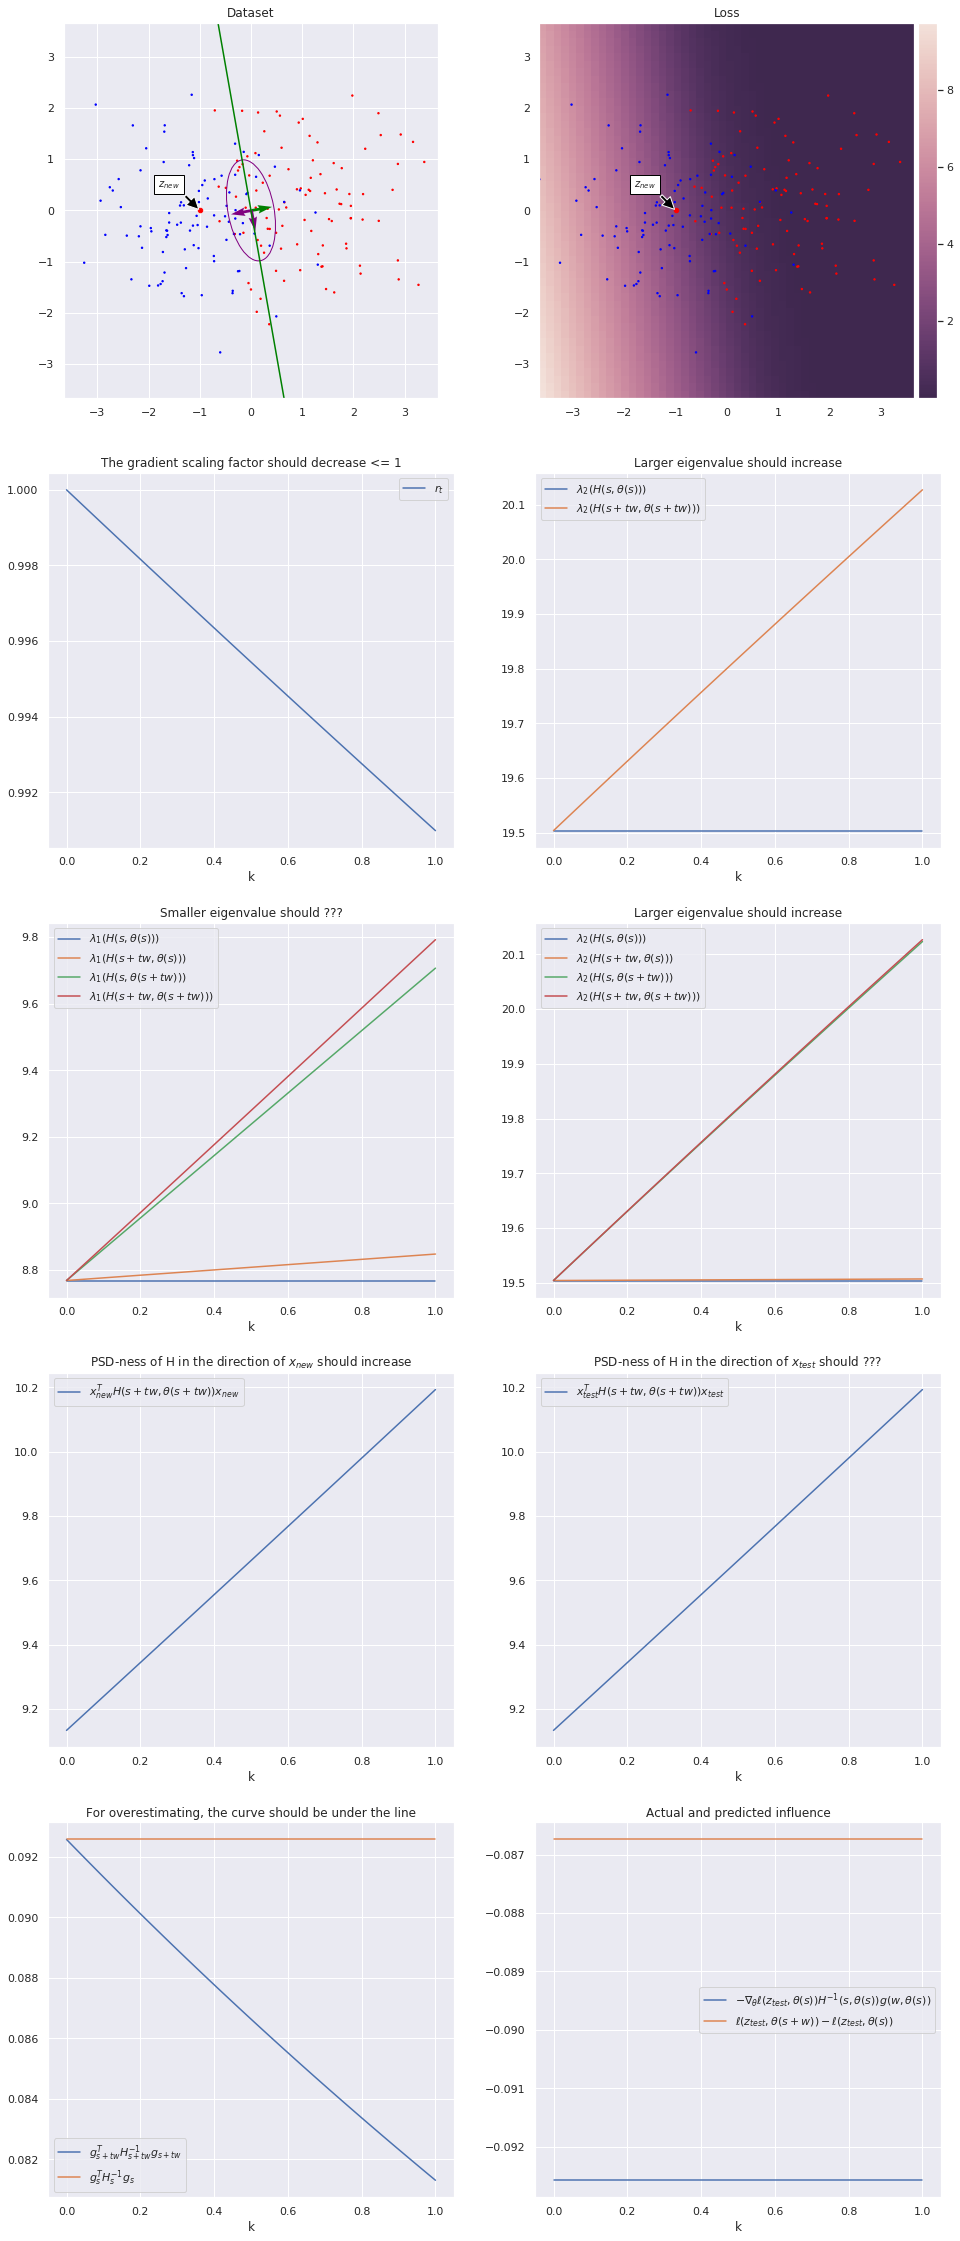

In [29]:
# Confusing
sample_integral(X, y, (np.array([-1, 0]), 1),
                row_types=["dataset", "self_infl_factors", "hess_eig", "hess_prod", "integrands"])

## Repeats: Points of least confidence

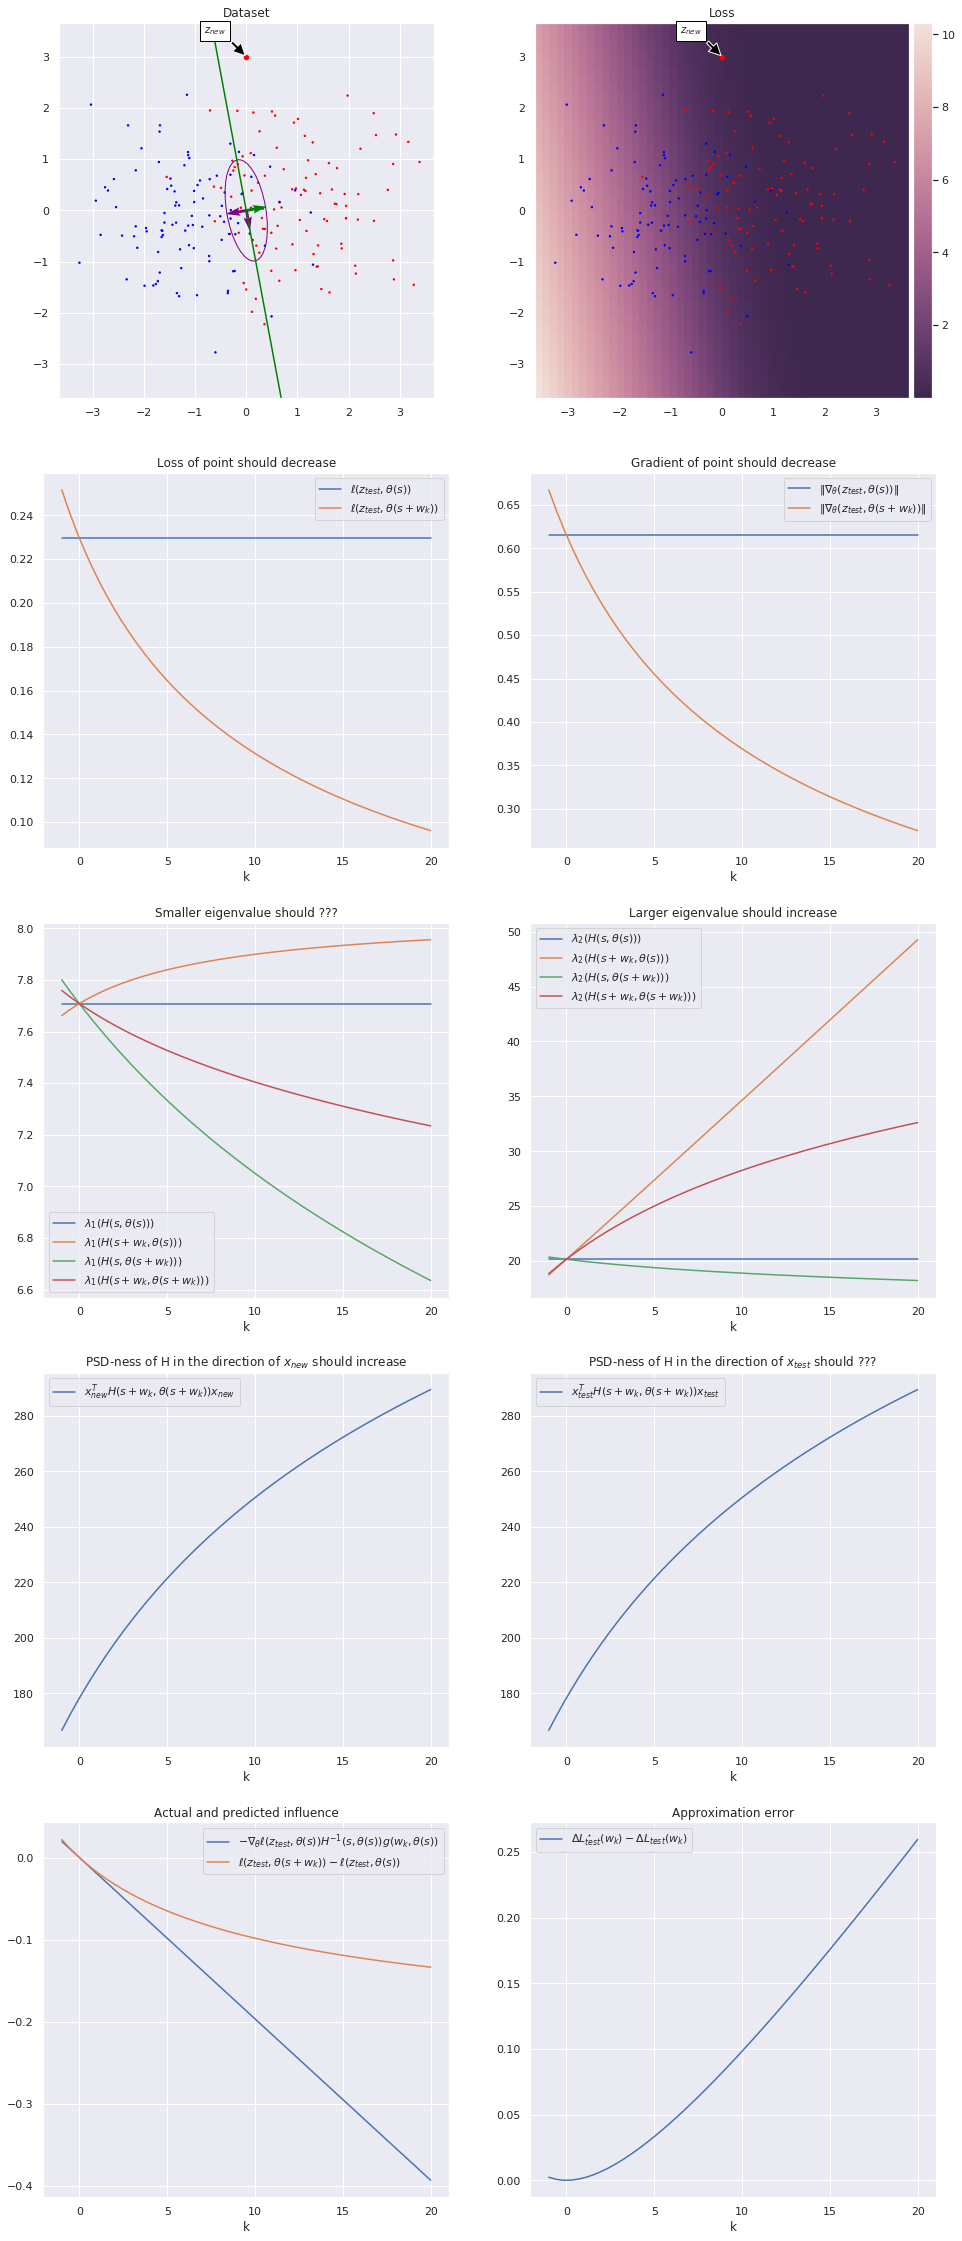

In [30]:
sample_repeats(X, y, (np.array([0, 3]), 1))

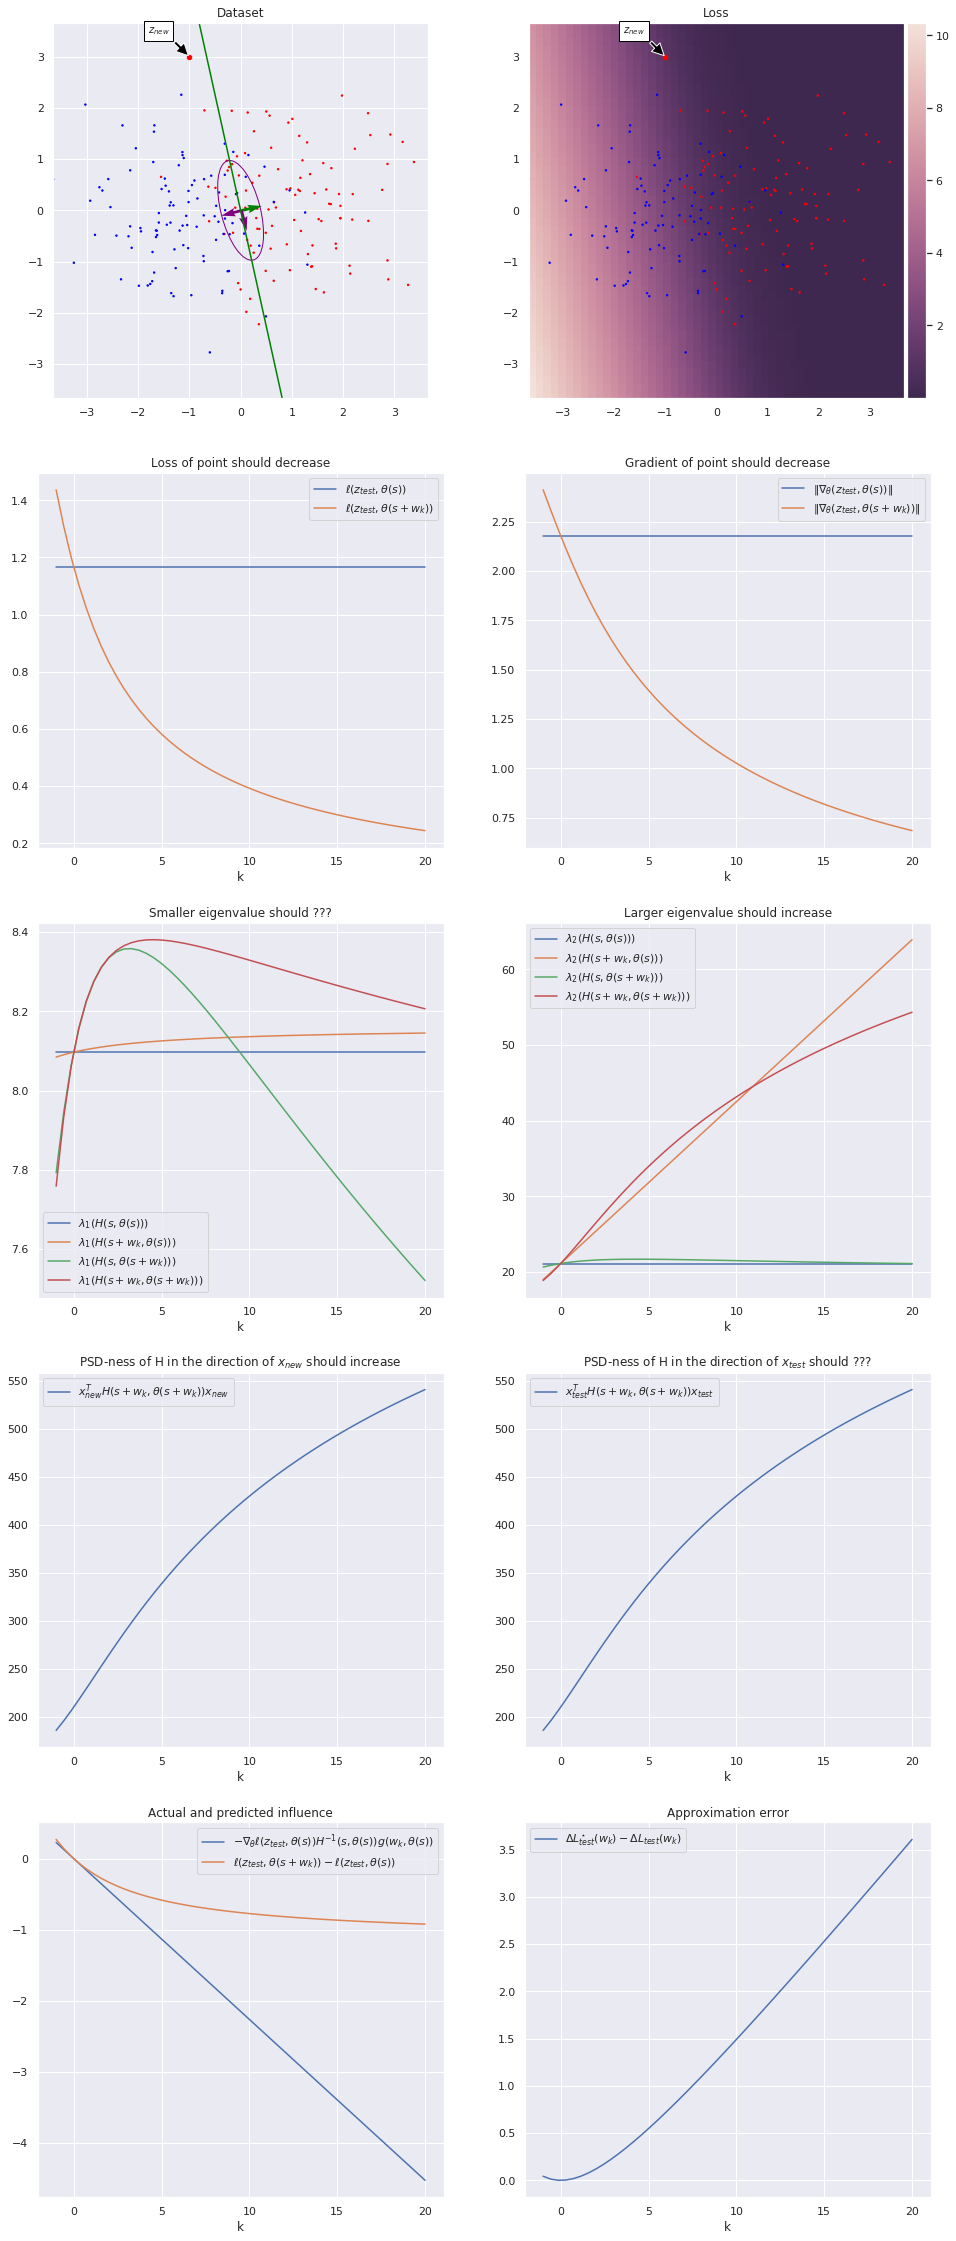

In [31]:
sample_repeats(X, y, (np.array([-1, 3]), 1))

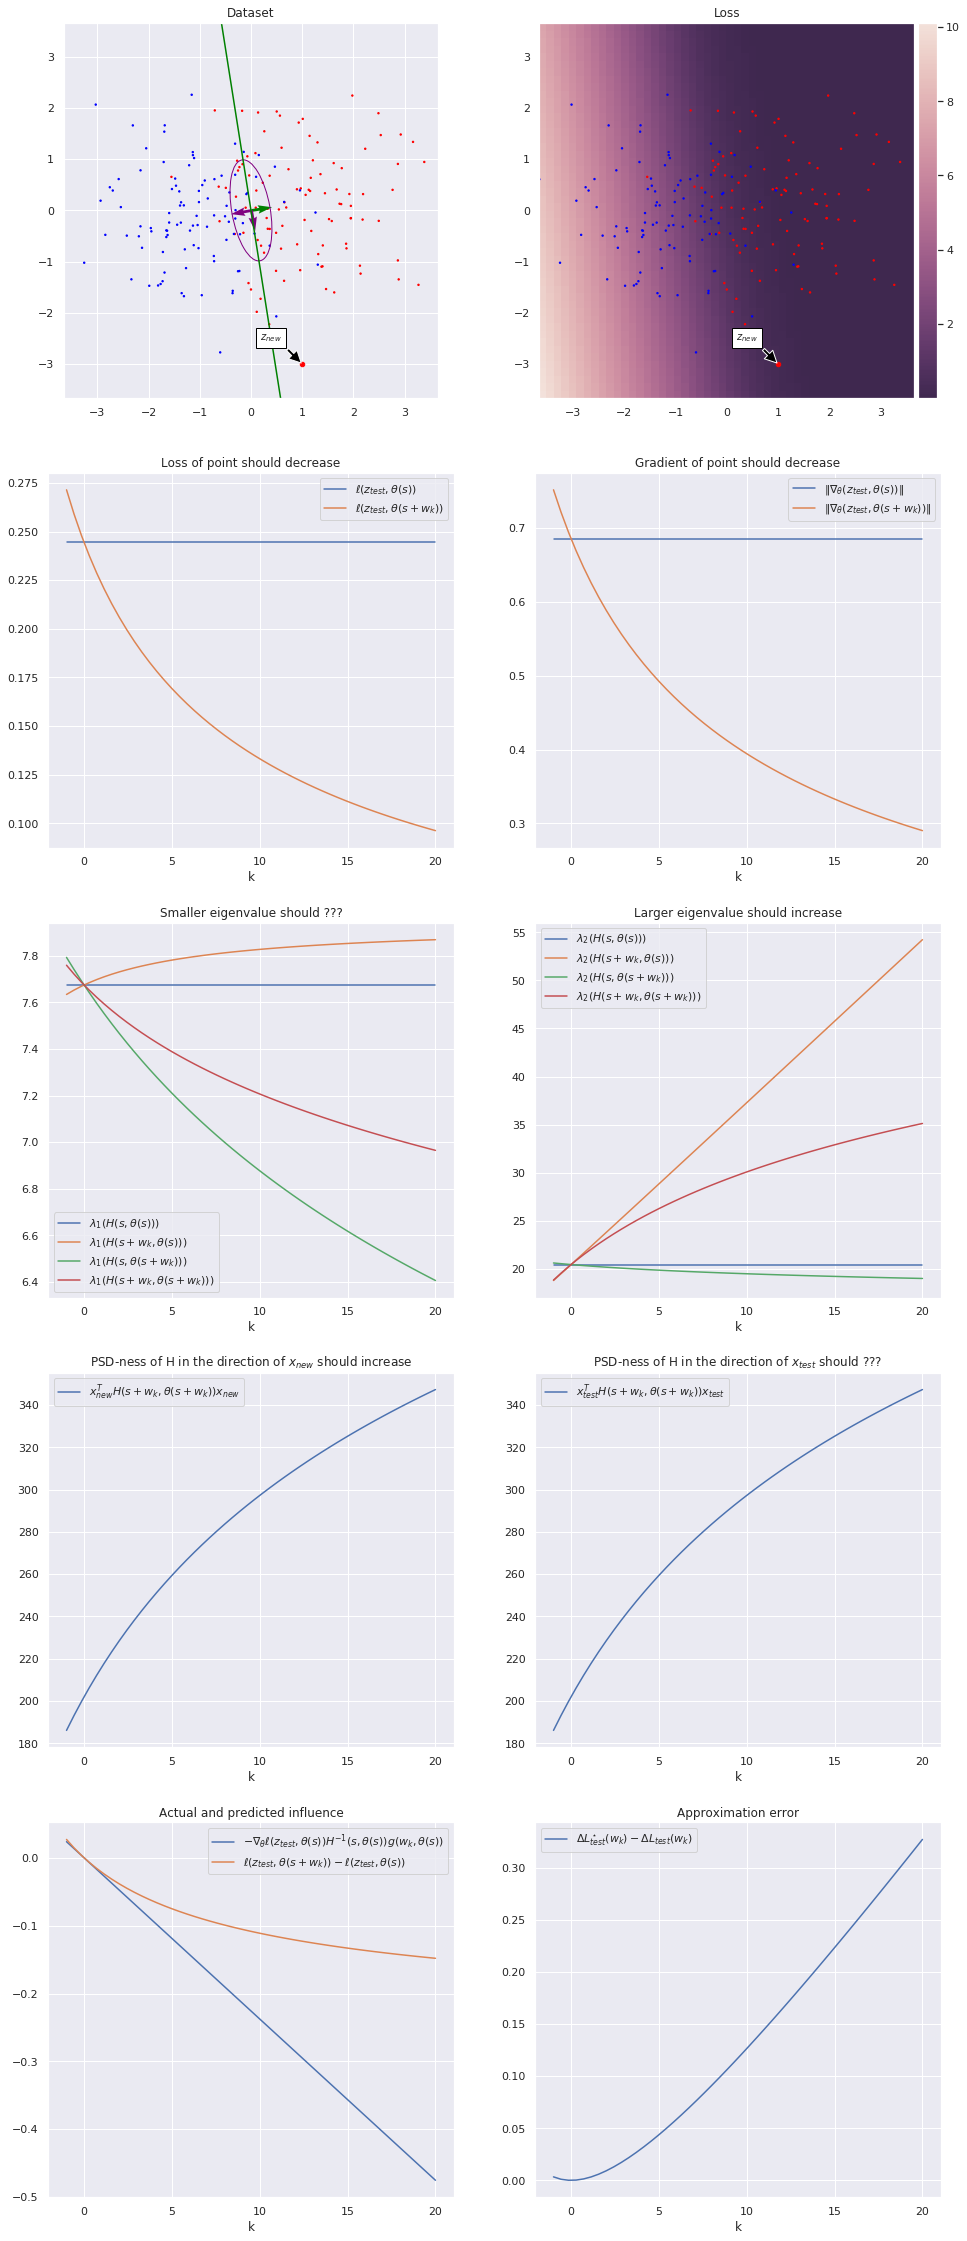

In [32]:
sample_repeats(X, y, (np.array([1, -3]), 1))

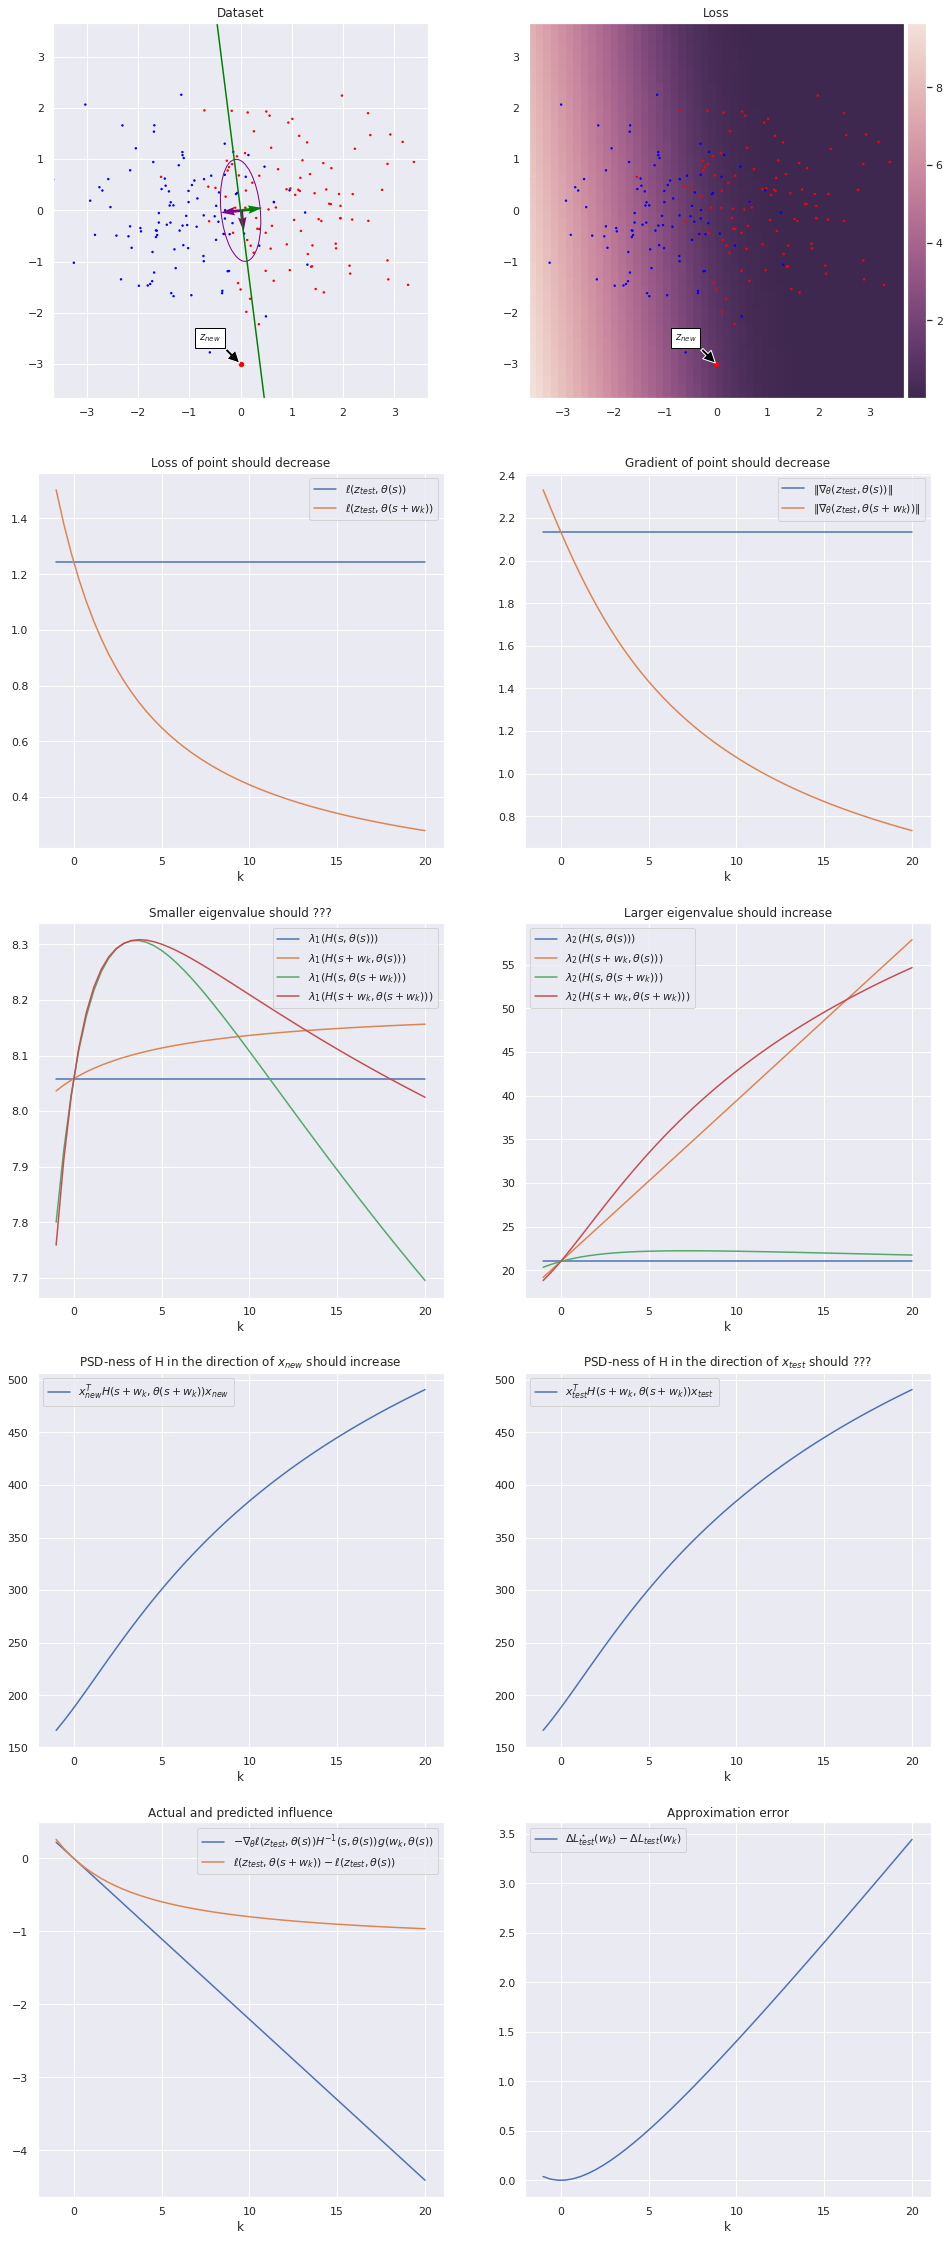

In [33]:
sample_repeats(X, y, (np.array([0, -3]), 1))

## Repeats: Far out points

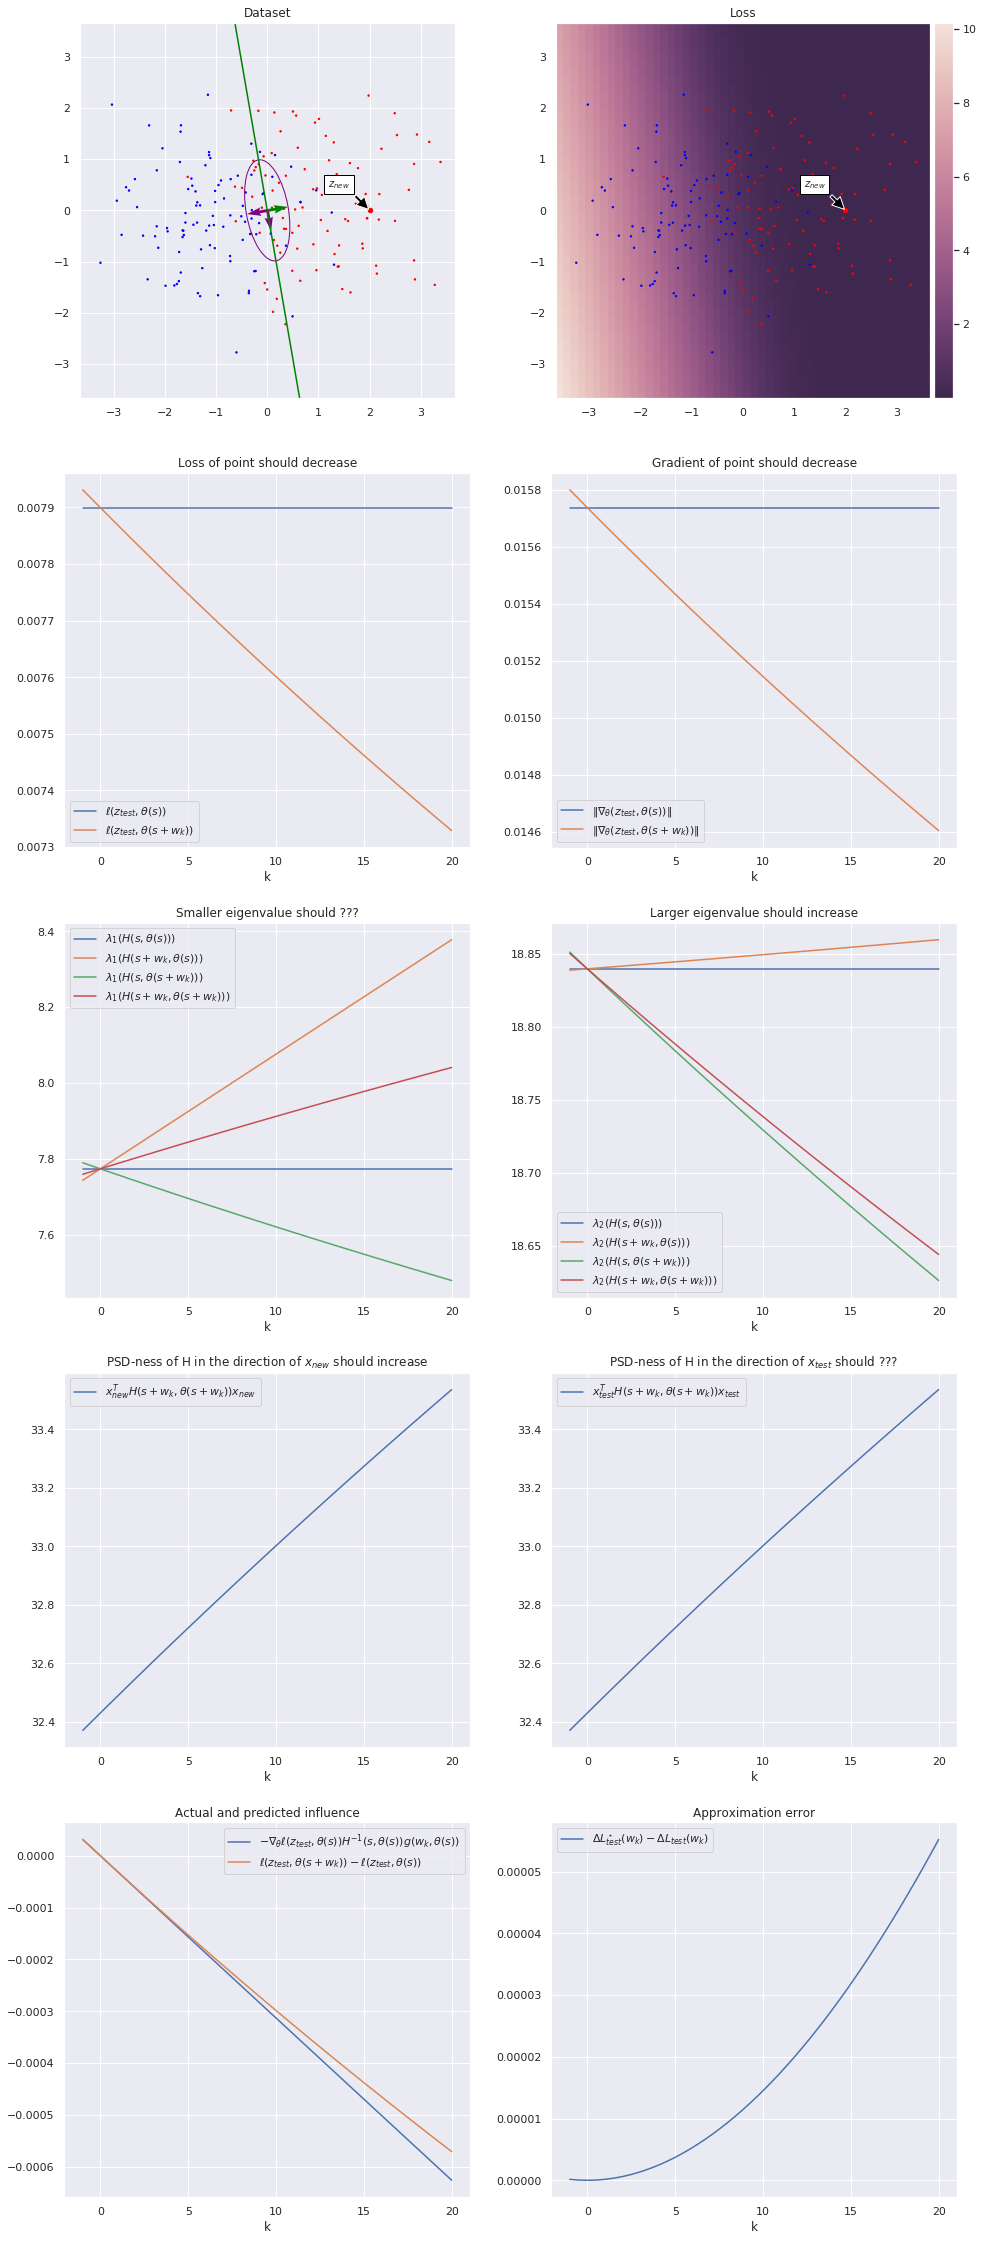

In [34]:
# Affirming
sample_repeats(X, y, (np.array([2, 0]), 1))

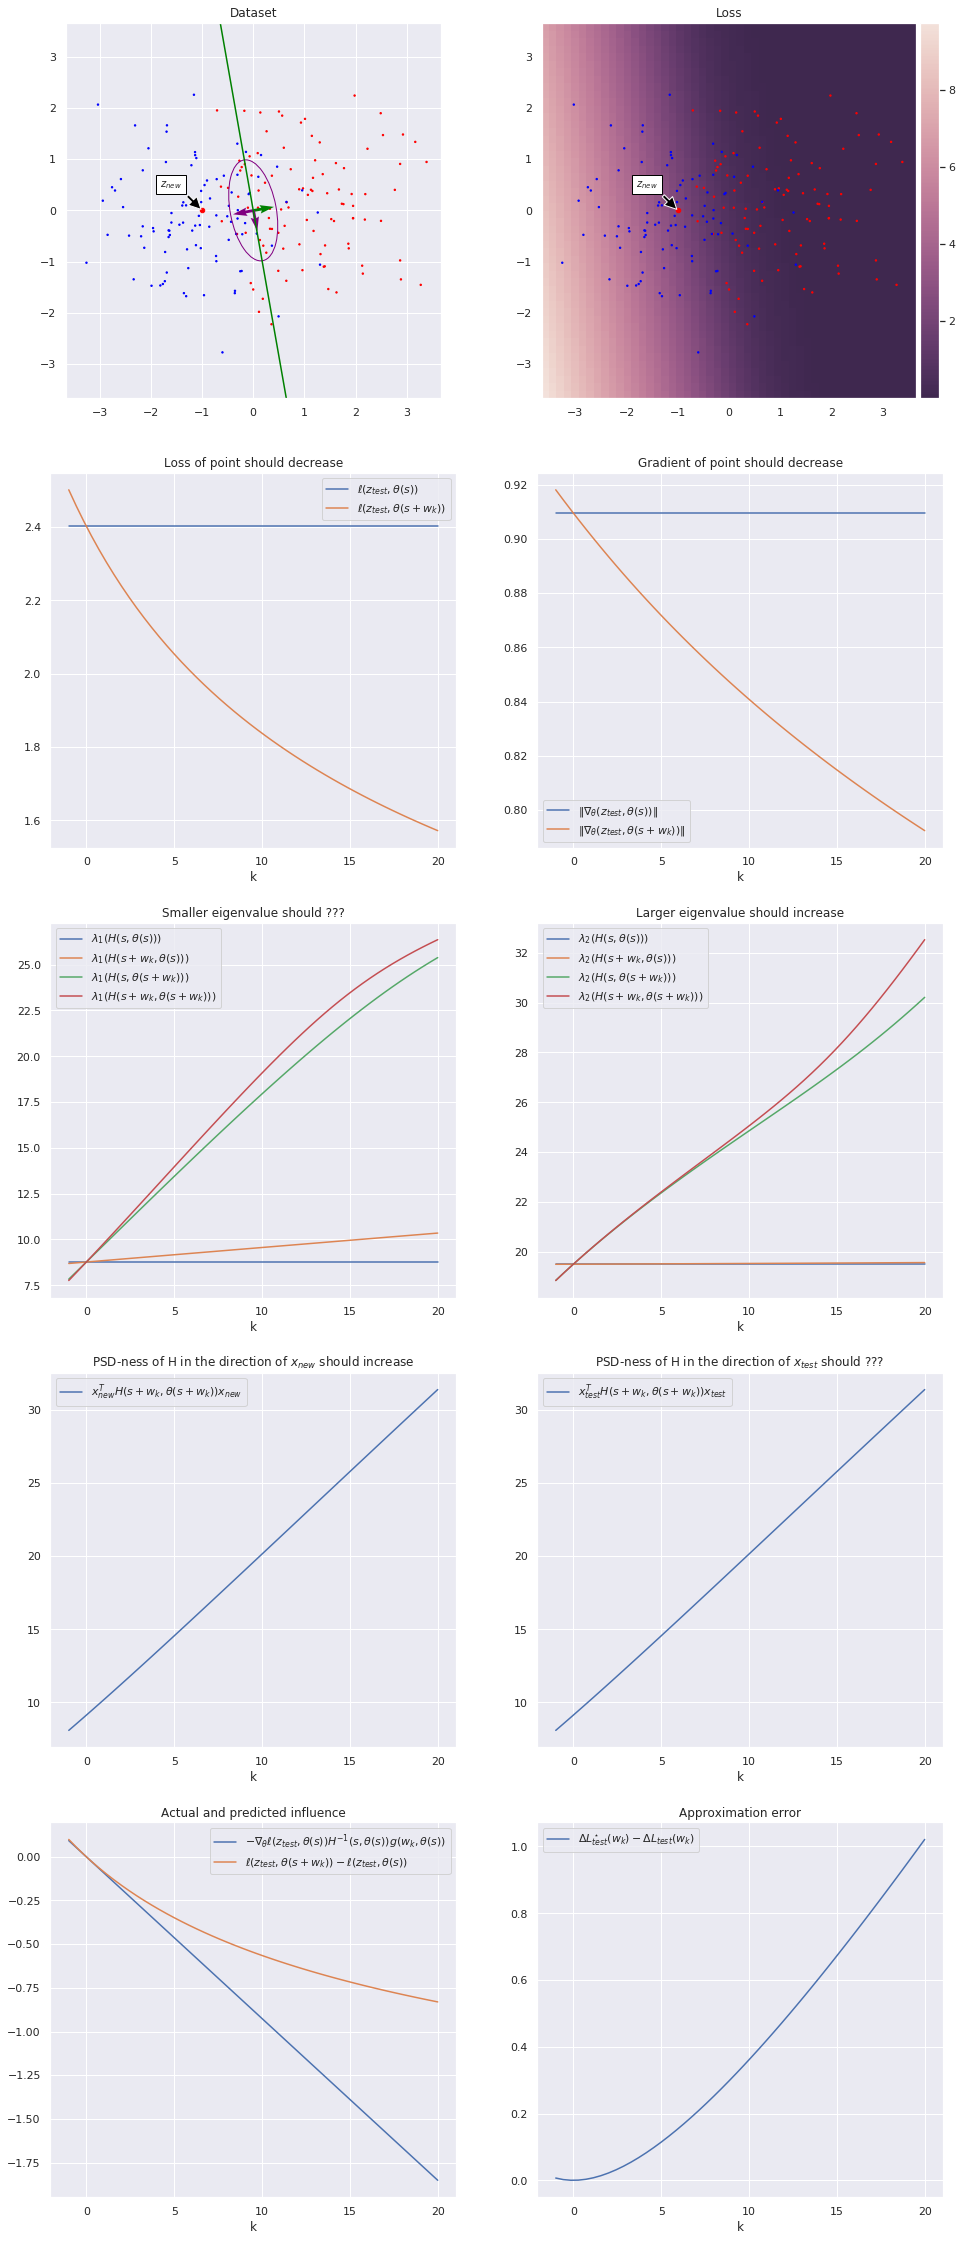

In [35]:
# Confusing
sample_repeats(X, y, (np.array([-1, 0]), 1))